In [1]:

# Import basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler

# import visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Sharpley value
import shap
import lime
import lime.lime_tabular


# stepwise
from mlxtend.feature_selection import SequentialFeatureSelector as sfs

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV



# statics
import scipy.stats as st
import torch

import random 

random.seed(10)


In [2]:
import pickle
#load the model
filename3 = 'xgb.sav'
optimal_xgb = pickle.load(open(filename3, 'rb'))

In [3]:
#Load the train and test data
X_train= pd.read_csv("./X_train.csv")
X_test= pd.read_csv("./X_test.csv")

X_train = X_train.drop(['Unnamed: 0'],axis=1)
X_test = X_test.drop(['Unnamed: 0'],axis=1)

In [4]:
#load the individual explanations of XGBoosting
xgb_df = pd.read_csv('./xgb_indi_exp.csv')

## Explainability Uncertainty 

In [9]:
# instance for individual explanations
choosen_instance = X_test.iloc[:1]
choosen_instance

,limit_bal,sex,age,pay_Sep,pay_Aug,pay_Jul,pay_Jun,pay_May,pay_Apr,bill_amt_Sep,...,pay_amt_Aug,pay_amt_Jul,pay_amt_Jun,pay_amt_May,pay_amt_Apr,education_graduate school,education_high school,education_university,marriage_married,marriage_single
0,-0.828424,0,-1.462993,3,2,2,2,2,2,0.140351,...,-0.100048,-0.279705,-0.148416,-0.229047,-0.293382,0,0,1,0,1


In [10]:
#function of calculating the L2 distance
def set_distance(dataset,p,q):
    num_feature = dataset._get_numeric_data().columns
    continuous_contribution = np.sum((p[num_feature].values.squeeze()-q[num_feature].values.squeeze())**2)
    return continuous_contribution

In [11]:
#compute the distance between chosen instances and remaining instance in testing dataset
dist=np.zeros(X_test.shape[0])
for i in range(X_test.shape[0]):
    q = X_test.iloc[i:(i+1)]
    dist[i] = set_distance(X_test,choosen_instance,q)
X_test['dist']=dist
sort_data=X_test.reindex(X_test.dist.sort_values(ascending=True).index)
sort_data

,limit_bal,sex,age,pay_Sep,pay_Aug,pay_Jul,pay_Jun,pay_May,pay_Apr,bill_amt_Sep,...,pay_amt_Jul,pay_amt_Jun,pay_amt_May,pay_amt_Apr,education_graduate school,education_high school,education_university,marriage_married,marriage_single,dist
0,-0.828424,0,-1.462993,3,2,2,2,2,2,0.140351,...,-0.279705,-0.148416,-0.229047,-0.293382,0,0,1,0,1,0.000000
7561,-0.751350,0,-1.029047,3,2,2,2,2,2,-0.027464,...,-0.183208,-0.180397,-0.314136,-0.065787,0,0,1,0,1,0.651774
6640,-0.674276,0,-1.029047,3,2,2,2,2,2,-0.083321,...,-0.183208,-0.308063,0.078584,-0.293382,0,0,1,0,1,0.701682
8131,-0.828424,0,-1.029047,2,2,2,2,2,2,0.125371,...,-0.296120,-0.103797,-0.208167,-0.293382,0,0,1,0,1,1.301149
7330,-0.905498,0,-1.137534,3,3,2,2,2,2,-0.212282,...,-0.211606,-0.196355,-0.223156,-0.293382,0,0,1,0,1,1.522568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3708,2.562830,0,0.815221,-1,-1,-1,0,0,-1,-0.641876,...,-0.013443,-0.301679,-0.301045,29.445098,0,0,1,0,1,1134.298295
1254,4.335531,1,0.164303,0,0,0,0,-1,0,0.259194,...,0.216357,33.452975,1.126165,0.550397,0,0,1,1,0,1325.135083
6156,3.410644,1,-0.486615,0,-1,2,-1,-1,-1,4.035719,...,19.547669,15.659359,17.430208,12.086317,1,0,0,0,1,1649.986007
1576,2.639904,0,-0.595102,-1,-1,-1,-1,0,0,0.270222,...,9.050623,-0.275508,0.094227,-0.037436,1,0,0,0,1,3954.844593


In [12]:
# set the k-nearest neighborhood
choosen_range = sort_data.iloc[:256]
choosen_range=choosen_range.drop(['dist'], axis=1)
choosen_range.shape

(256, 26)

#### XGBoosting

In [9]:
choosen_range_xgb=choosen_range.copy()
choosen_range_xgb.iloc[:,21:26]=choosen_range_xgb.iloc[:,21:26].astype('int64')
choosen_range_xgb.iloc[:,3:9]=choosen_range_xgb.iloc[:,3:9].astype('int64')
choosen_range_xgb.iloc[:,1]=choosen_range_xgb.iloc[:,1].astype('int64')

In [10]:
# function to compute the uncertainty intervals of xgboosting's explanations 
def bootstrap_xgb(fit,x_data, n_samples,sample_size,explainer,backset):
    n_features=x_data.shape[1]
    total = torch.zeros(n_samples,n_features)
    d = {'Feature': backset.columns, 'col2': np.zeros(26)}
    columns =  pd.DataFrame(data=d)
    ci=np.zeros([n_features,2])
    for i in range(n_samples):
        bootstrap_sample = x_data.sample(n=sample_size,replace=True)
        bootstrap_index = bootstrap_sample.index.values# sample indeices in test dataset
        if explainer=='shap':
            # calculate the shapley values
            explainer_shap = shap.Explainer(fit, backset)
            shap_values = explainer_shap(bootstrap_sample,check_additivity=False).values
            mean_shap = shap_values.mean(axis=0)
            total[i,:]=torch.from_numpy(mean_shap)

        if explainer=='lime':
            lime_values=np.zeros(n_features)
            explainer_lime = lime.lime_tabular.LimeTabularExplainer(backset.values, feature_names=backset.columns.values.tolist(), class_names=['0','1'], verbose=True,mode='classification',discretize_continuous=False)
            for j in range(sample_size):
                lime_exp = explainer_lime.explain_instance(bootstrap_sample.iloc[j,:], fit.predict_proba,num_features=26)
                df=pd.DataFrame(lime_exp.as_list(),columns=['Feature','Contribution'])
                df=pd.merge(columns, df, left_on='Feature', right_on='Feature', how='left')
                lime_values = lime_values+df['Contribution'].to_numpy()
            total[i,:]=torch.from_numpy(lime_values/sample_size)
            
    for j in range(n_features):
        ci[j,0]=torch.quantile(total[:,j], 0.025, interpolation='nearest')
        ci[j,1]=torch.quantile(total[:,j], 0.975, interpolation='nearest')
    return(ci)

In [13]:
xgb_train=X_train.copy()
xgb_train.iloc[:,21:26]=xgb_train.iloc[:,21:26].astype('int64')
xgb_train.iloc[:,3:9]=xgb_train.iloc[:,3:9].astype('int64')
xgb_train.iloc[:,1]=xgb_train.iloc[:,1].astype('int64')

xgb_test = X_test.copy()
xgb_test.iloc[:,21:26]=xgb_test.iloc[:,21:26].astype('int64')
xgb_test.iloc[:,3:9]=xgb_test.iloc[:,3:9].astype('int64')
xgb_test.iloc[:,1]=xgb_test.iloc[:,1].astype('int64')

In [12]:
# compute the uncertainty of Shapley values
shap_ci=bootstrap_xgb(optimal_xgb,choosen_range, 200,70,'shap',xgb_train)

In [13]:
# compute the uncertainty of LIME coefficients
lime_ci=bootstrap_xgb(optimal_xgb,choosen_range, 200,70,'lime',xgb_train)

Intercept 0.341423679170191
Prediction_local [0.58317206]
Right: 0.7669733
Intercept 0.34025450044459193
Prediction_local [0.61880428]
Right: 0.74424905
Intercept 0.33878687098935373
Prediction_local [0.50574285]
Right: 0.5733501
Intercept 0.3400567240487114
Prediction_local [0.58768174]
Right: 0.81691724
Intercept 0.34122760724991813
Prediction_local [0.53331006]
Right: 0.68388116
Intercept 0.34095417744786916
Prediction_local [0.56805245]
Right: 0.64856374
Intercept 0.34145099810823565
Prediction_local [0.52676906]
Right: 0.5833271
Intercept 0.33867213963869536
Prediction_local [0.51791748]
Right: 0.5103952
Intercept 0.3410181056379434
Prediction_local [0.59703749]
Right: 0.78590083
Intercept 0.34115518499617153
Prediction_local [0.56579923]
Right: 0.7274066
Intercept 0.3424922353306155
Prediction_local [0.504745]
Right: 0.71636814
Intercept 0.340887212211093
Prediction_local [0.58805175]
Right: 0.8108354
Intercept 0.34045770398883557
Prediction_local [0.57833641]
Right: 0.7542283
In

Intercept 0.34070296782986803
Prediction_local [0.58997601]
Right: 0.8247104
Intercept 0.33974282678985124
Prediction_local [0.53959298]
Right: 0.77273864
Intercept 0.33993906923550227
Prediction_local [0.64126467]
Right: 0.76844096
Intercept 0.3410599841873238
Prediction_local [0.58328558]
Right: 0.6397617
Intercept 0.34002174333332136
Prediction_local [0.54944735]
Right: 0.7729289
Intercept 0.3391141253354098
Prediction_local [0.58604505]
Right: 0.793555
Intercept 0.3406216200998559
Prediction_local [0.58672571]
Right: 0.71952766
Intercept 0.33927097544053836
Prediction_local [0.5912417]
Right: 0.8040337
Intercept 0.34253220701754106
Prediction_local [0.571718]
Right: 0.79911894
Intercept 0.33940104845165486
Prediction_local [0.60400063]
Right: 0.75261086
Intercept 0.3403973139243199
Prediction_local [0.56883867]
Right: 0.797369
Intercept 0.338041317652989
Prediction_local [0.56939616]
Right: 0.7542283
Intercept 0.3407939483853922
Prediction_local [0.52631954]
Right: 0.57449365
Inter

Intercept 0.33822985951777007
Prediction_local [0.71892776]
Right: 0.6312694
Intercept 0.3388685891545774
Prediction_local [0.58345245]
Right: 0.7952479
Intercept 0.3407306260837869
Prediction_local [0.59841748]
Right: 0.7822614
Intercept 0.3400747038976442
Prediction_local [0.66029947]
Right: 0.7450966
Intercept 0.3402204234785478
Prediction_local [0.57470341]
Right: 0.7537369
Intercept 0.3397245281373541
Prediction_local [0.53325275]
Right: 0.6623541
Intercept 0.34220102244936224
Prediction_local [0.59429589]
Right: 0.779144
Intercept 0.34161985006616824
Prediction_local [0.5708517]
Right: 0.7908081
Intercept 0.3411682515883844
Prediction_local [0.57640628]
Right: 0.8057966
Intercept 0.34193808685455485
Prediction_local [0.52228748]
Right: 0.5160839
Intercept 0.3381483528516652
Prediction_local [0.53272544]
Right: 0.55678606
Intercept 0.3412905630091106
Prediction_local [0.58628969]
Right: 0.7950838
Intercept 0.34113449822723335
Prediction_local [0.60602702]
Right: 0.7492368
Intercep

Intercept 0.33844247463546645
Prediction_local [0.53563181]
Right: 0.704227
Intercept 0.33926109696747764
Prediction_local [0.55753588]
Right: 0.7274066
Intercept 0.34119024160315437
Prediction_local [0.72179178]
Right: 0.6312694
Intercept 0.3385817226664195
Prediction_local [0.50699758]
Right: 0.5713454
Intercept 0.3398941559174881
Prediction_local [0.58921431]
Right: 0.78212744
Intercept 0.3387225065952947
Prediction_local [0.58121454]
Right: 0.781985
Intercept 0.3418782727593121
Prediction_local [0.58961368]
Right: 0.7357272
Intercept 0.34143004184768305
Prediction_local [0.57449926]
Right: 0.73568535
Intercept 0.34002463336987154
Prediction_local [0.58826019]
Right: 0.6449029
Intercept 0.3407045507795276
Prediction_local [0.75870891]
Right: 0.6803927
Intercept 0.3384372024515685
Prediction_local [0.57004479]
Right: 0.75365585
Intercept 0.3388916480758164
Prediction_local [0.57309916]
Right: 0.71952766
Intercept 0.3400145414754488
Prediction_local [0.58548592]
Right: 0.8247104
Inter

Intercept 0.33902284704178565
Prediction_local [0.55935797]
Right: 0.6587029
Intercept 0.3406527727297521
Prediction_local [0.53355255]
Right: 0.5833271
Intercept 0.3408977789120575
Prediction_local [0.55152313]
Right: 0.7433629
Intercept 0.339400230046183
Prediction_local [0.58030498]
Right: 0.75594985
Intercept 0.3401082337771805
Prediction_local [0.65056206]
Right: 0.71997106
Intercept 0.34066635575542353
Prediction_local [0.63733736]
Right: 0.7951829
Intercept 0.3409383647805322
Prediction_local [0.5756632]
Right: 0.72617084
Intercept 0.3402775362375011
Prediction_local [0.61171803]
Right: 0.7430586
Intercept 0.34202106074120664
Prediction_local [0.52603104]
Right: 0.7405842
Intercept 0.3396490226261121
Prediction_local [0.53287761]
Right: 0.6915995
Intercept 0.3398298719426396
Prediction_local [0.65082776]
Right: 0.74992
Intercept 0.33990859512999816
Prediction_local [0.60779079]
Right: 0.7430586
Intercept 0.3388063038038365
Prediction_local [0.56986029]
Right: 0.7639209
Intercept

Intercept 0.3401011248195588
Prediction_local [0.60943346]
Right: 0.7980522
Intercept 0.33927964638330255
Prediction_local [0.66821805]
Right: 0.77209103
Intercept 0.3414104576893461
Prediction_local [0.59435589]
Right: 0.7967029
Intercept 0.33861989703736656
Prediction_local [0.57717709]
Right: 0.7550263
Intercept 0.3415441295222333
Prediction_local [0.64473707]
Right: 0.74462646
Intercept 0.3402766845258087
Prediction_local [0.66074479]
Right: 0.77209103
Intercept 0.3398026454446117
Prediction_local [0.53240815]
Right: 0.5231994
Intercept 0.3401855320812894
Prediction_local [0.58673066]
Right: 0.7378293
Intercept 0.3375860482723917
Prediction_local [0.63872919]
Right: 0.7623007
Intercept 0.34083406175934605
Prediction_local [0.59613217]
Right: 0.79641706
Intercept 0.33989969074029347
Prediction_local [0.53644609]
Right: 0.6413045
Intercept 0.34254124043248546
Prediction_local [0.5344789]
Right: 0.69373256
Intercept 0.3403872198062713
Prediction_local [0.58214059]
Right: 0.7556036
Int

Intercept 0.34006692621462675
Prediction_local [0.51421591]
Right: 0.5713454
Intercept 0.3409570349495925
Prediction_local [0.5340787]
Right: 0.6883827
Intercept 0.34128684870006
Prediction_local [0.58346899]
Right: 0.7669733
Intercept 0.3410608682466805
Prediction_local [0.53849907]
Right: 0.692061
Intercept 0.3420901092505604
Prediction_local [0.59636998]
Right: 0.6449029
Intercept 0.34344355431401224
Prediction_local [0.5822312]
Right: 0.7958021
Intercept 0.34120433469525885
Prediction_local [0.61802315]
Right: 0.76844096
Intercept 0.3419167954732595
Prediction_local [0.57909275]
Right: 0.7757265
Intercept 0.34031183520114217
Prediction_local [0.57719447]
Right: 0.77575845
Intercept 0.3395325282597961
Prediction_local [0.59220885]
Right: 0.75594985
Intercept 0.340840421971624
Prediction_local [0.59960454]
Right: 0.8045601
Intercept 0.33817197006144056
Prediction_local [0.62632957]
Right: 0.7951829
Intercept 0.3394664747372413
Prediction_local [0.59920588]
Right: 0.7823225
Intercept 

Intercept 0.34073387632902613
Prediction_local [0.56810387]
Right: 0.7698335
Intercept 0.3420026484287146
Prediction_local [0.57953585]
Right: 0.7862264
Intercept 0.33991935532330236
Prediction_local [0.60606644]
Right: 0.79002243
Intercept 0.33953379328017
Prediction_local [0.58699604]
Right: 0.8085499
Intercept 0.33827106723957157
Prediction_local [0.5816741]
Right: 0.8247104
Intercept 0.3394160645577744
Prediction_local [0.57076411]
Right: 0.7876334
Intercept 0.33880675408743827
Prediction_local [0.6570287]
Right: 0.71997106
Intercept 0.34100377777836777
Prediction_local [0.53797142]
Right: 0.65507495
Intercept 0.33798152508624385
Prediction_local [0.60393034]
Right: 0.73474514
Intercept 0.3413221834512403
Prediction_local [0.64795755]
Right: 0.76211464
Intercept 0.33992398390418843
Prediction_local [0.58291334]
Right: 0.6397617
Intercept 0.34078741987166516
Prediction_local [0.52689105]
Right: 0.5231994
Intercept 0.33955147660324425
Prediction_local [0.59945572]
Right: 0.77373207
I

Intercept 0.3410526281572728
Prediction_local [0.60305749]
Right: 0.6880634
Intercept 0.3404529165552502
Prediction_local [0.52276463]
Right: 0.6861353
Intercept 0.3414622853529186
Prediction_local [0.59310957]
Right: 0.8045601
Intercept 0.339520299536221
Prediction_local [0.58816003]
Right: 0.77884936
Intercept 0.33993463360232923
Prediction_local [0.59418288]
Right: 0.79083437
Intercept 0.33854370593958905
Prediction_local [0.53384136]
Right: 0.65612215
Intercept 0.3401156117557116
Prediction_local [0.53518216]
Right: 0.7154539
Intercept 0.33861983390849726
Prediction_local [0.58138054]
Right: 0.7678921
Intercept 0.34039875691908417
Prediction_local [0.59420991]
Right: 0.78316724
Intercept 0.34118823716873065
Prediction_local [0.51325919]
Right: 0.58656424
Intercept 0.33992387085558096
Prediction_local [0.51696158]
Right: 0.7957187
Intercept 0.34013505215621104
Prediction_local [0.63768424]
Right: 0.7828883
Intercept 0.33996908900211953
Prediction_local [0.56259383]
Right: 0.7698335


Intercept 0.33842456374801644
Prediction_local [0.65074301]
Right: 0.75407314
Intercept 0.33912696081084936
Prediction_local [0.58461402]
Right: 0.6853166
Intercept 0.3406840803070052
Prediction_local [0.59159767]
Right: 0.7986602
Intercept 0.3401160308992756
Prediction_local [0.57615469]
Right: 0.79911894
Intercept 0.33905351872018075
Prediction_local [0.59353872]
Right: 0.8040337
Intercept 0.33890522569540577
Prediction_local [0.57730314]
Right: 0.75437057
Intercept 0.34145300988359817
Prediction_local [0.59139717]
Right: 0.79318404
Intercept 0.34007489660497253
Prediction_local [0.59165388]
Right: 0.6397617
Intercept 0.34057827269907737
Prediction_local [0.58743109]
Right: 0.7670952
Intercept 0.34039604123729655
Prediction_local [0.64372586]
Right: 0.7580628
Intercept 0.33949364085174244
Prediction_local [0.59782162]
Right: 0.78212744
Intercept 0.3391499380156607
Prediction_local [0.64525838]
Right: 0.752301
Intercept 0.3398876796640682
Prediction_local [0.60166606]
Right: 0.789983


Intercept 0.34059943034464
Prediction_local [0.55564913]
Right: 0.6807972
Intercept 0.34079939974439455
Prediction_local [0.58272721]
Right: 0.7986602
Intercept 0.33877562329220745
Prediction_local [0.64536657]
Right: 0.752301
Intercept 0.33897311895495386
Prediction_local [0.51468959]
Right: 0.69081396
Intercept 0.3399779395513941
Prediction_local [0.53391122]
Right: 0.5731201
Intercept 0.3389906200347824
Prediction_local [0.52273381]
Right: 0.7347965
Intercept 0.34164789468702794
Prediction_local [0.52621412]
Right: 0.57449365
Intercept 0.33947872923922046
Prediction_local [0.56368419]
Right: 0.751535
Intercept 0.34089053400314234
Prediction_local [0.55369836]
Right: 0.69545907
Intercept 0.34183912477778605
Prediction_local [0.52697637]
Right: 0.56260395
Intercept 0.33953541511370594
Prediction_local [0.56187195]
Right: 0.7274066
Intercept 0.33995965196141553
Prediction_local [0.57803845]
Right: 0.77884936
Intercept 0.3410029009605951
Prediction_local [0.61244208]
Right: 0.7566525
In

Intercept 0.3395661653331553
Prediction_local [0.62697811]
Right: 0.7359152
Intercept 0.3409020530093028
Prediction_local [0.63117999]
Right: 0.76844096
Intercept 0.3408583811172325
Prediction_local [0.59379165]
Right: 0.78590083
Intercept 0.34116943772723046
Prediction_local [0.6157996]
Right: 0.7492368
Intercept 0.3406483572491729
Prediction_local [0.58513644]
Right: 0.7950838
Intercept 0.3391016477640957
Prediction_local [0.55212734]
Right: 0.75884223
Intercept 0.33883476702078463
Prediction_local [0.5826756]
Right: 0.77575845
Intercept 0.34085824316997293
Prediction_local [0.54697451]
Right: 0.65507495
Intercept 0.34068602675686593
Prediction_local [0.52302925]
Right: 0.532887
Intercept 0.3411237603067521
Prediction_local [0.5927101]
Right: 0.8085499
Intercept 0.3397143933401323
Prediction_local [0.60228213]
Right: 0.8108354
Intercept 0.3394137346902645
Prediction_local [0.59316698]
Right: 0.7378293
Intercept 0.33996319863778796
Prediction_local [0.63616925]
Right: 0.7580628
Interc

Intercept 0.33982171615685947
Prediction_local [0.57924725]
Right: 0.7268117
Intercept 0.34053022814900763
Prediction_local [0.59178387]
Right: 0.75261086
Intercept 0.33987345980777633
Prediction_local [0.73598532]
Right: 0.7480723
Intercept 0.3409537067975724
Prediction_local [0.59132133]
Right: 0.7678921
Intercept 0.3399799799036523
Prediction_local [0.54435903]
Right: 0.6413045
Intercept 0.3404460364782449
Prediction_local [0.63669553]
Right: 0.71997106
Intercept 0.3396561423733668
Prediction_local [0.58873075]
Right: 0.77676404
Intercept 0.34039468811866236
Prediction_local [0.58228557]
Right: 0.76362175
Intercept 0.34027438314743075
Prediction_local [0.50055055]
Right: 0.5713454
Intercept 0.33955137924664536
Prediction_local [0.57839008]
Right: 0.7740188
Intercept 0.3413457823713601
Prediction_local [0.52596148]
Right: 0.69373256
Intercept 0.3384697805318196
Prediction_local [0.66590875]
Right: 0.7524727
Intercept 0.3418478338532111
Prediction_local [0.55007858]
Right: 0.6807972
I

Intercept 0.33999114543231174
Prediction_local [0.57969777]
Right: 0.77373207
Intercept 0.3392501541712982
Prediction_local [0.75419714]
Right: 0.6803927
Intercept 0.3399009315113553
Prediction_local [0.69085618]
Right: 0.7160515
Intercept 0.34326396635334205
Prediction_local [0.53427911]
Right: 0.5637032
Intercept 0.34094428922907444
Prediction_local [0.49717961]
Right: 0.69703424
Intercept 0.33945281579668185
Prediction_local [0.57364809]
Right: 0.79381806
Intercept 0.34085217165643955
Prediction_local [0.5925796]
Right: 0.7594398
Intercept 0.33903063646998344
Prediction_local [0.57394138]
Right: 0.7886132
Intercept 0.3390188797970972
Prediction_local [0.58422988]
Right: 0.7556036
Intercept 0.34097738226723173
Prediction_local [0.62812968]
Right: 0.752301
Intercept 0.33964194456653607
Prediction_local [0.62511159]
Right: 0.72954994
Intercept 0.34162912285039687
Prediction_local [0.65534279]
Right: 0.77063084
Intercept 0.3394208871448077
Prediction_local [0.59363292]
Right: 0.8007363


Intercept 0.33980897349504297
Prediction_local [0.58275528]
Right: 0.7563008
Intercept 0.3412345614211808
Prediction_local [0.59711722]
Right: 0.76331586
Intercept 0.3392201879370324
Prediction_local [0.72043757]
Right: 0.70273584
Intercept 0.339205730380214
Prediction_local [0.59294059]
Right: 0.8040337
Intercept 0.33816022743858604
Prediction_local [0.58778434]
Right: 0.77575845
Intercept 0.3414274696813723
Prediction_local [0.50548528]
Right: 0.6477473
Intercept 0.3409597318905386
Prediction_local [0.68802745]
Right: 0.7524727
Intercept 0.34121555447721613
Prediction_local [0.59319197]
Right: 0.72617084
Intercept 0.3400623335198022
Prediction_local [0.51956774]
Right: 0.5731201
Intercept 0.34265766231072875
Prediction_local [0.53391878]
Right: 0.68076164
Intercept 0.34081072693797665
Prediction_local [0.54973296]
Right: 0.77273864
Intercept 0.3408944133668621
Prediction_local [0.59101206]
Right: 0.71147287
Intercept 0.341242805442833
Prediction_local [0.51876183]
Right: 0.6477473
In

Intercept 0.34019479735401026
Prediction_local [0.60103823]
Right: 0.77575845
Intercept 0.34116577626914296
Prediction_local [0.60233039]
Right: 0.751315
Intercept 0.3415831762204863
Prediction_local [0.59125336]
Right: 0.7886132
Intercept 0.34102506879215355
Prediction_local [0.53236921]
Right: 0.7347965
Intercept 0.3385125512442137
Prediction_local [0.58614743]
Right: 0.7961713
Intercept 0.3416205835611976
Prediction_local [0.59197552]
Right: 0.78316724
Intercept 0.3386916759591973
Prediction_local [0.57449068]
Right: 0.7823225
Intercept 0.3387205547297779
Prediction_local [0.77668671]
Right: 0.6803927
Intercept 0.3394824819875634
Prediction_local [0.59601036]
Right: 0.6880634
Intercept 0.3394209135894973
Prediction_local [0.58052328]
Right: 0.7678921
Intercept 0.33791558240062075
Prediction_local [0.52332754]
Right: 0.71636814
Intercept 0.33917409262456555
Prediction_local [0.55030971]
Right: 0.751535
Intercept 0.3370206519968803
Prediction_local [0.57949252]
Right: 0.7952479
Interc

Intercept 0.34022865010094755
Prediction_local [0.58122903]
Right: 0.79381806
Intercept 0.3403220841574702
Prediction_local [0.57852453]
Right: 0.7757265
Intercept 0.3397959432100988
Prediction_local [0.56896356]
Right: 0.7958021
Intercept 0.34053418933921054
Prediction_local [0.57805291]
Right: 0.75365585
Intercept 0.3404650204406031
Prediction_local [0.57476634]
Right: 0.71675515
Intercept 0.34127790568554595
Prediction_local [0.53021008]
Right: 0.7405842
Intercept 0.3374565817681576
Prediction_local [0.57349301]
Right: 0.75884223
Intercept 0.3393597834037616
Prediction_local [0.7182696]
Right: 0.7358394
Intercept 0.3405861593969852
Prediction_local [0.59635748]
Right: 0.78212744
Intercept 0.3421668129787675
Prediction_local [0.5757738]
Right: 0.6952291
Intercept 0.34102256371776385
Prediction_local [0.53794647]
Right: 0.72118074
Intercept 0.34249739039994037
Prediction_local [0.54173016]
Right: 0.7220482
Intercept 0.34017113039017527
Prediction_local [0.61137107]
Right: 0.7430586
In

Intercept 0.33983940131175616
Prediction_local [0.54486954]
Right: 0.7410014
Intercept 0.34005639349963923
Prediction_local [0.53078041]
Right: 0.7220482
Intercept 0.3415032072087051
Prediction_local [0.58925935]
Right: 0.7633532
Intercept 0.3401405642649413
Prediction_local [0.57749119]
Right: 0.71952766
Intercept 0.3393397551487335
Prediction_local [0.51870183]
Right: 0.5103952
Intercept 0.34102165562840875
Prediction_local [0.59661257]
Right: 0.8007131
Intercept 0.34042668549766303
Prediction_local [0.53342487]
Right: 0.6807972
Intercept 0.3395721683655673
Prediction_local [0.59029091]
Right: 0.6853166
Intercept 0.3398386906038279
Prediction_local [0.74789695]
Right: 0.7251592
Intercept 0.3392519774493592
Prediction_local [0.64641146]
Right: 0.7270185
Intercept 0.338884303138399
Prediction_local [0.57940333]
Right: 0.7537369
Intercept 0.33919620899121394
Prediction_local [0.63187263]
Right: 0.75407314
Intercept 0.3396757888354215
Prediction_local [0.58071496]
Right: 0.75437057
Inter

Intercept 0.3415003150385144
Prediction_local [0.51392427]
Right: 0.5733501
Intercept 0.3382863514728044
Prediction_local [0.57523497]
Right: 0.7864533
Intercept 0.34010500541025884
Prediction_local [0.52890623]
Right: 0.55678606
Intercept 0.33961564829036966
Prediction_local [0.6363851]
Right: 0.752301
Intercept 0.3407960516695378
Prediction_local [0.56700746]
Right: 0.6860253
Intercept 0.3397026952600532
Prediction_local [0.57783763]
Right: 0.75138056
Intercept 0.3404070428789247
Prediction_local [0.57830097]
Right: 0.72617084
Intercept 0.33926879878069977
Prediction_local [0.51824597]
Right: 0.5411678
Intercept 0.3388025795856367
Prediction_local [0.59386458]
Right: 0.7566525
Intercept 0.34046588008200923
Prediction_local [0.6508762]
Right: 0.77209103
Intercept 0.33948837338077925
Prediction_local [0.64598454]
Right: 0.7270185
Intercept 0.340290692620155
Prediction_local [0.64485785]
Right: 0.7623007
Intercept 0.34058804726211084
Prediction_local [0.61068279]
Right: 0.73373145
Inter

Intercept 0.33889802204605224
Prediction_local [0.76224364]
Right: 0.6803927
Intercept 0.3414988702231301
Prediction_local [0.5262232]
Right: 0.5103952
Intercept 0.34027048315162983
Prediction_local [0.7662115]
Right: 0.6803927
Intercept 0.3394668538123219
Prediction_local [0.58319021]
Right: 0.7986602
Intercept 0.34142808832345073
Prediction_local [0.58152787]
Right: 0.7344706
Intercept 0.34079340971520594
Prediction_local [0.56103571]
Right: 0.6860253
Intercept 0.3388980136474504
Prediction_local [0.59626396]
Right: 0.78212744
Intercept 0.3417682732848241
Prediction_local [0.5286814]
Right: 0.5731201
Intercept 0.3381675176184383
Prediction_local [0.52359884]
Right: 0.532887
Intercept 0.34014938910561054
Prediction_local [0.56625733]
Right: 0.64856374
Intercept 0.3414075960550275
Prediction_local [0.52825426]
Right: 0.5731201
Intercept 0.340578040551276
Prediction_local [0.74049058]
Right: 0.73858476
Intercept 0.3419154161009812
Prediction_local [0.59384726]
Right: 0.8108354
Intercept

Intercept 0.34076807156342065
Prediction_local [0.59517787]
Right: 0.78285825
Intercept 0.3400112999611321
Prediction_local [0.54061525]
Right: 0.72682214
Intercept 0.34014016592309027
Prediction_local [0.57140702]
Right: 0.7422465
Intercept 0.33916068652669407
Prediction_local [0.59229567]
Right: 0.7744982
Intercept 0.3416012286053803
Prediction_local [0.5335667]
Right: 0.7220482
Intercept 0.33952191477473365
Prediction_local [0.57943764]
Right: 0.75756145
Intercept 0.3416351625902974
Prediction_local [0.59224823]
Right: 0.7510786
Intercept 0.34003614137272736
Prediction_local [0.53158841]
Right: 0.7154539
Intercept 0.34017244519713985
Prediction_local [0.66037666]
Right: 0.71997106
Intercept 0.341091151730902
Prediction_local [0.59793447]
Right: 0.81691724
Intercept 0.34103848384619867
Prediction_local [0.52597935]
Right: 0.5833271
Intercept 0.341098128039126
Prediction_local [0.59998187]
Right: 0.77373207
Intercept 0.34078352420528074
Prediction_local [0.59768628]
Right: 0.7678921
I

Intercept 0.34083548834545785
Prediction_local [0.58186271]
Right: 0.781985
Intercept 0.3412577887040753
Prediction_local [0.58920129]
Right: 0.7975241
Intercept 0.33859495763335595
Prediction_local [0.72120375]
Right: 0.73858476
Intercept 0.33992795719139857
Prediction_local [0.58709571]
Right: 0.7823209
Intercept 0.34037756571130956
Prediction_local [0.58603828]
Right: 0.75365585
Intercept 0.34103215830716704
Prediction_local [0.54143295]
Right: 0.6915995
Intercept 0.3392877721065445
Prediction_local [0.57767526]
Right: 0.77393305
Intercept 0.3399452313735664
Prediction_local [0.59001132]
Right: 0.8040337
Intercept 0.338224236573123
Prediction_local [0.57841693]
Right: 0.75310445
Intercept 0.3413714841372484
Prediction_local [0.67057653]
Right: 0.77185124
Intercept 0.3414925369897482
Prediction_local [0.59449051]
Right: 0.79318404
Intercept 0.3394631633678677
Prediction_local [0.58856768]
Right: 0.7967029
Intercept 0.3408687443844752
Prediction_local [0.58569313]
Right: 0.77676404
In

Intercept 0.3401507739037206
Prediction_local [0.52673293]
Right: 0.6623541
Intercept 0.3389518894650071
Prediction_local [0.56759002]
Right: 0.78026986
Intercept 0.3401726687710554
Prediction_local [0.59439696]
Right: 0.7542283
Intercept 0.340970586892656
Prediction_local [0.59678072]
Right: 0.6920469
Intercept 0.34014265092660434
Prediction_local [0.53953627]
Right: 0.7729289
Intercept 0.3404168258177085
Prediction_local [0.5768015]
Right: 0.6952291
Intercept 0.3373327877249598
Prediction_local [0.60463644]
Right: 0.73373145
Intercept 0.3412919020344168
Prediction_local [0.53435934]
Right: 0.68076164
Intercept 0.3415905685478235
Prediction_local [0.54360083]
Right: 0.6587029
Intercept 0.3408807497142429
Prediction_local [0.73079545]
Right: 0.7479101
Intercept 0.3387452440691535
Prediction_local [0.71967676]
Right: 0.6312694
Intercept 0.34084759727205105
Prediction_local [0.55546771]
Right: 0.64856374
Intercept 0.3393806009782051
Prediction_local [0.49733358]
Right: 0.69703424
Interce

Intercept 0.34041761874470566
Prediction_local [0.56508955]
Right: 0.73397946
Intercept 0.34138534717377916
Prediction_local [0.55404707]
Right: 0.75365585
Intercept 0.33893478414748623
Prediction_local [0.59199277]
Right: 0.7744982
Intercept 0.33984151661240886
Prediction_local [0.5779353]
Right: 0.7412983
Intercept 0.34044120375610115
Prediction_local [0.58397645]
Right: 0.7952479
Intercept 0.3392657774015786
Prediction_local [0.59962027]
Right: 0.71909165
Intercept 0.3427131590633449
Prediction_local [0.58824493]
Right: 0.8007363
Intercept 0.34128422321889595
Prediction_local [0.56558497]
Right: 0.68763614
Intercept 0.33918526202083643
Prediction_local [0.57790196]
Right: 0.7908081
Intercept 0.34115970220983627
Prediction_local [0.58655523]
Right: 0.77125347
Intercept 0.3406825488455578
Prediction_local [0.58504787]
Right: 0.78316724
Intercept 0.3391117411985087
Prediction_local [0.58390242]
Right: 0.78285825
Intercept 0.34171970649255234
Prediction_local [0.58588345]
Right: 0.75422

Intercept 0.3405675767991881
Prediction_local [0.53537794]
Right: 0.6915995
Intercept 0.3382951123639661
Prediction_local [0.5358529]
Right: 0.6413045
Intercept 0.3404835007570229
Prediction_local [0.52217716]
Right: 0.6883827
Intercept 0.3410870951417426
Prediction_local [0.53922895]
Right: 0.7405842
Intercept 0.3402183286651707
Prediction_local [0.59039756]
Right: 0.8085499
Intercept 0.3389041346142333
Prediction_local [0.60846665]
Right: 0.71909165
Intercept 0.34010201396185236
Prediction_local [0.57635907]
Right: 0.7888683
Intercept 0.3398303465121195
Prediction_local [0.58956798]
Right: 0.7961713
Intercept 0.33840018160345336
Prediction_local [0.61822642]
Right: 0.79843426
Intercept 0.34140598315558623
Prediction_local [0.55207434]
Right: 0.7433629
Intercept 0.34016152329718746
Prediction_local [0.63852845]
Right: 0.77063084
Intercept 0.34227739336682395
Prediction_local [0.57854239]
Right: 0.7823209
Intercept 0.34082394900182844
Prediction_local [0.59258613]
Right: 0.72617084
Int

Intercept 0.33935895338489436
Prediction_local [0.59589582]
Right: 0.78084886
Intercept 0.3382610510596296
Prediction_local [0.58899208]
Right: 0.7677318
Intercept 0.34024144916552673
Prediction_local [0.63468659]
Right: 0.7951829
Intercept 0.3417035473437726
Prediction_local [0.53898478]
Right: 0.72682214
Intercept 0.3417218307074246
Prediction_local [0.51186014]
Right: 0.5713454
Intercept 0.3425963894501759
Prediction_local [0.5661583]
Right: 0.6952291
Intercept 0.3396123145526633
Prediction_local [0.72984729]
Right: 0.70273584
Intercept 0.3408330908494758
Prediction_local [0.56680535]
Right: 0.75884223
Intercept 0.33983195785789855
Prediction_local [0.57422147]
Right: 0.7594398
Intercept 0.34116681113218345
Prediction_local [0.64411996]
Right: 0.77109337
Intercept 0.34016540680411084
Prediction_local [0.58427815]
Right: 0.77998716
Intercept 0.3415213414391115
Prediction_local [0.62150328]
Right: 0.73474514
Intercept 0.3400276210758527
Prediction_local [0.68771422]
Right: 0.7160515
I

Intercept 0.3423024157664707
Prediction_local [0.54286058]
Right: 0.61556554
Intercept 0.339959779056467
Prediction_local [0.59209745]
Right: 0.77884936
Intercept 0.3425924983887605
Prediction_local [0.58362556]
Right: 0.7561719
Intercept 0.34060072696863647
Prediction_local [0.576962]
Right: 0.71675515
Intercept 0.3410181326952821
Prediction_local [0.56500378]
Right: 0.68763614
Intercept 0.3411105628804641
Prediction_local [0.58688534]
Right: 0.81551117
Intercept 0.3413020224761613
Prediction_local [0.72947908]
Right: 0.7479101
Intercept 0.34032130462835614
Prediction_local [0.57504767]
Right: 0.792153
Intercept 0.34123902561125513
Prediction_local [0.5309694]
Right: 0.64754045
Intercept 0.34015346391304757
Prediction_local [0.64554742]
Right: 0.77063084
Intercept 0.34030698889882444
Prediction_local [0.58126454]
Right: 0.75920486
Intercept 0.3397177341585137
Prediction_local [0.57048102]
Right: 0.73568535
Intercept 0.33928677499091026
Prediction_local [0.58053757]
Right: 0.7975241
In

Intercept 0.34008709731869696
Prediction_local [0.57524283]
Right: 0.79911894
Intercept 0.34191096843032115
Prediction_local [0.54505877]
Right: 0.6413045
Intercept 0.3410126820368772
Prediction_local [0.59491073]
Right: 0.76966375
Intercept 0.34135283053273247
Prediction_local [0.57515007]
Right: 0.72617084
Intercept 0.3392726129897712
Prediction_local [0.56468404]
Right: 0.7958021
Intercept 0.34161410677599774
Prediction_local [0.54715036]
Right: 0.6915995
Intercept 0.3409309049505826
Prediction_local [0.565247]
Right: 0.7698335
Intercept 0.33750260297717316
Prediction_local [0.55460213]
Right: 0.64856374
Intercept 0.3401646565372428
Prediction_local [0.52919442]
Right: 0.71452904
Intercept 0.33800201431360316
Prediction_local [0.74608699]
Right: 0.7251592
Intercept 0.3407078686049458
Prediction_local [0.75364426]
Right: 0.7251592
Intercept 0.3418531650935421
Prediction_local [0.50228219]
Right: 0.58656424
Intercept 0.3410123745274141
Prediction_local [0.58694923]
Right: 0.7999597
In

Intercept 0.3423864470467154
Prediction_local [0.57962545]
Right: 0.77368397
Intercept 0.34045618949987816
Prediction_local [0.52734936]
Right: 0.532887
Intercept 0.3384428611125038
Prediction_local [0.58029068]
Right: 0.778519
Intercept 0.33804802228385267
Prediction_local [0.69828798]
Right: 0.6312694
Intercept 0.338360951953732
Prediction_local [0.57818581]
Right: 0.7757265
Intercept 0.3389833646498836
Prediction_local [0.57705661]
Right: 0.7537369
Intercept 0.33941383173585804
Prediction_local [0.56579272]
Right: 0.68763614
Intercept 0.34072727420211724
Prediction_local [0.58485041]
Right: 0.77676404
Intercept 0.34060667431428804
Prediction_local [0.59280883]
Right: 0.7422465
Intercept 0.34101369980437934
Prediction_local [0.5833606]
Right: 0.7561719
Intercept 0.3399801110454596
Prediction_local [0.58984256]
Right: 0.7753582
Intercept 0.3423797844029773
Prediction_local [0.58851567]
Right: 0.7757265
Intercept 0.3393502847202485
Prediction_local [0.55849934]
Right: 0.8041063
Interce

Intercept 0.3392776491999257
Prediction_local [0.52283202]
Right: 0.69081396
Intercept 0.3377287141059523
Prediction_local [0.72316711]
Right: 0.70273584
Intercept 0.34054904588191803
Prediction_local [0.58511289]
Right: 0.78316724
Intercept 0.34049972871635126
Prediction_local [0.72235374]
Right: 0.70273584
Intercept 0.3406668745369324
Prediction_local [0.6024793]
Right: 0.7516529
Intercept 0.3406199412246884
Prediction_local [0.61493833]
Right: 0.7430586
Intercept 0.34182404871750616
Prediction_local [0.66444871]
Right: 0.7623007
Intercept 0.3412036103102242
Prediction_local [0.59566028]
Right: 0.793555
Intercept 0.34141501647736217
Prediction_local [0.55095881]
Right: 0.692061
Intercept 0.33827674758201676
Prediction_local [0.62275802]
Right: 0.74424905
Intercept 0.34171488405491796
Prediction_local [0.58710568]
Right: 0.7598895
Intercept 0.340397635114405
Prediction_local [0.58797964]
Right: 0.77676404
Intercept 0.3409090455686261
Prediction_local [0.64990645]
Right: 0.74462646
Int

Intercept 0.34145234383130146
Prediction_local [0.52883519]
Right: 0.5978058
Intercept 0.3391723594668538
Prediction_local [0.52701734]
Right: 0.72021395
Intercept 0.3409252204965917
Prediction_local [0.54153746]
Right: 0.65612215
Intercept 0.34035513945941215
Prediction_local [0.57716195]
Right: 0.7598895
Intercept 0.3407596791263503
Prediction_local [0.58297757]
Right: 0.7268117
Intercept 0.342099787916406
Prediction_local [0.59729515]
Right: 0.73959565
Intercept 0.3405842635028652
Prediction_local [0.70201675]
Right: 0.7627708
Intercept 0.34127833881184116
Prediction_local [0.5813843]
Right: 0.78590083
Intercept 0.339494310575728
Prediction_local [0.58739351]
Right: 0.78156525
Intercept 0.34058882730695095
Prediction_local [0.59546876]
Right: 0.76966375
Intercept 0.3390186414779402
Prediction_local [0.58662171]
Right: 0.7670952
Intercept 0.3398758677427856
Prediction_local [0.62267501]
Right: 0.72954994
Intercept 0.34052936036334996
Prediction_local [0.52286074]
Right: 0.55678606
In

Intercept 0.33969932049949786
Prediction_local [0.58050915]
Right: 0.7412983
Intercept 0.34089407378509445
Prediction_local [0.52347788]
Right: 0.5666879
Intercept 0.34162024375332917
Prediction_local [0.59486758]
Right: 0.77368397
Intercept 0.3371585348002241
Prediction_local [0.51686807]
Right: 0.71636814
Intercept 0.34178340515120503
Prediction_local [0.59410993]
Right: 0.8040337
Intercept 0.3376399988720559
Prediction_local [0.59434729]
Right: 0.8040337
Intercept 0.34008477354295935
Prediction_local [0.57871968]
Right: 0.75365585
Intercept 0.3391992532253893
Prediction_local [0.58075007]
Right: 0.7561719
Intercept 0.3406401650423918
Prediction_local [0.57704031]
Right: 0.75660056
Intercept 0.33917214692643116
Prediction_local [0.56950864]
Right: 0.77393305
Intercept 0.341051626066946
Prediction_local [0.6013344]
Right: 0.7358273
Intercept 0.34080783692711275
Prediction_local [0.5331094]
Right: 0.57978606
Intercept 0.3398313788665541
Prediction_local [0.67469191]
Right: 0.77185124
I

Intercept 0.33701931124365864
Prediction_local [0.59998313]
Right: 0.61987144
Intercept 0.3387810826995055
Prediction_local [0.65506353]
Right: 0.7450966
Intercept 0.3380650240294648
Prediction_local [0.57894459]
Right: 0.77125347
Intercept 0.3411773502604191
Prediction_local [0.52845872]
Right: 0.5978058
Intercept 0.3408271780795752
Prediction_local [0.58149455]
Right: 0.81551117
Intercept 0.3398695404577515
Prediction_local [0.59607072]
Right: 0.7847395
Intercept 0.33967569750639537
Prediction_local [0.64298222]
Right: 0.74992
Intercept 0.34095957826631945
Prediction_local [0.59104317]
Right: 0.7422465
Intercept 0.342317027096649
Prediction_local [0.58049296]
Right: 0.614681
Intercept 0.3411273943084512
Prediction_local [0.57038789]
Right: 0.7274066
Intercept 0.3407614148299035
Prediction_local [0.53309657]
Right: 0.68076164
Intercept 0.3421368323515803
Prediction_local [0.54413876]
Right: 0.72118074
Intercept 0.3395533604099301
Prediction_local [0.53363626]
Right: 0.72682214
Interce

Intercept 0.3408147627697275
Prediction_local [0.52745496]
Right: 0.5666879
Intercept 0.3418286719312252
Prediction_local [0.53705461]
Right: 0.7154539
Intercept 0.34015206347169424
Prediction_local [0.57367354]
Right: 0.7639209
Intercept 0.34145254288932414
Prediction_local [0.58610723]
Right: 0.77368397
Intercept 0.33793195507393936
Prediction_local [0.59432059]
Right: 0.8085499
Intercept 0.341627543376048
Prediction_local [0.59754437]
Right: 0.789983
Intercept 0.3403514411525354
Prediction_local [0.5888376]
Right: 0.76966375
Intercept 0.34269258285745674
Prediction_local [0.59542365]
Right: 0.8174614
Intercept 0.34161256203377127
Prediction_local [0.57524355]
Right: 0.73397946
Intercept 0.33895313334582466
Prediction_local [0.64255655]
Right: 0.74462646
Intercept 0.3392913143985353
Prediction_local [0.57899674]
Right: 0.7556036
Intercept 0.339807734789492
Prediction_local [0.59612998]
Right: 0.751315
Intercept 0.3393504240546839
Prediction_local [0.57951444]
Right: 0.7669733
Interce

Intercept 0.3405850083850006
Prediction_local [0.68499977]
Right: 0.7445019
Intercept 0.3396292267970993
Prediction_local [0.60524736]
Right: 0.79002243
Intercept 0.3400281156730746
Prediction_local [0.59602173]
Right: 0.6853166
Intercept 0.33850886896316057
Prediction_local [0.61010047]
Right: 0.73959565
Intercept 0.3409503085256391
Prediction_local [0.58870657]
Right: 0.7510786
Intercept 0.34131677848176567
Prediction_local [0.59168792]
Right: 0.76362175
Intercept 0.33894943694017055
Prediction_local [0.58511658]
Right: 0.75594985
Intercept 0.33935449787785393
Prediction_local [0.73944478]
Right: 0.73858476
Intercept 0.34170748936046635
Prediction_local [0.57789948]
Right: 0.7605711
Intercept 0.3406601414127248
Prediction_local [0.66996721]
Right: 0.7524727
Intercept 0.341162384620051
Prediction_local [0.57541386]
Right: 0.75660056
Intercept 0.3401905553666734
Prediction_local [0.58449461]
Right: 0.7862264
Intercept 0.33982277997842303
Prediction_local [0.48872346]
Right: 0.69703424


Intercept 0.34117508951508857
Prediction_local [0.51575946]
Right: 0.5411678
Intercept 0.3416581894127685
Prediction_local [0.51770067]
Right: 0.5231994
Intercept 0.33885373859925405
Prediction_local [0.57687803]
Right: 0.7744982
Intercept 0.3413739930302373
Prediction_local [0.55855852]
Right: 0.68763614
Intercept 0.3414174138417341
Prediction_local [0.55976701]
Right: 0.6788079
Intercept 0.3409277494984946
Prediction_local [0.58584031]
Right: 0.7510786
Intercept 0.34089987560240986
Prediction_local [0.55092647]
Right: 0.68763614
Intercept 0.33937190238385917
Prediction_local [0.54584708]
Right: 0.6915995
Intercept 0.34075134288886916
Prediction_local [0.53377642]
Right: 0.58472925
Intercept 0.33959441540845187
Prediction_local [0.57402864]
Right: 0.7925622
Intercept 0.34043409575681377
Prediction_local [0.56639734]
Right: 0.6788079
Intercept 0.33766730105199333
Prediction_local [0.57242076]
Right: 0.7950838
Intercept 0.33941593403827935
Prediction_local [0.73697469]
Right: 0.7358394


Intercept 0.3389971181974143
Prediction_local [0.5797991]
Right: 0.793555
Intercept 0.3396847621533392
Prediction_local [0.58175097]
Right: 0.7556036
Intercept 0.3402847229353792
Prediction_local [0.54851765]
Right: 0.7410014
Intercept 0.3397882687108921
Prediction_local [0.60188126]
Right: 0.7358273
Intercept 0.3401061519869601
Prediction_local [0.53503256]
Right: 0.57978606
Intercept 0.33990773391963935
Prediction_local [0.62910347]
Right: 0.76211464
Intercept 0.3410045472407867
Prediction_local [0.59070624]
Right: 0.6853166
Intercept 0.3398808425784525
Prediction_local [0.58261461]
Right: 0.77676404
Intercept 0.34208562380474944
Prediction_local [0.57145922]
Right: 0.7888683
Intercept 0.3439993137824068
Prediction_local [0.55587681]
Right: 0.6807972
Intercept 0.3413682937114744
Prediction_local [0.59874565]
Right: 0.789983
Intercept 0.340095196810887
Prediction_local [0.53024545]
Right: 0.64754045
Intercept 0.34013175476820673
Prediction_local [0.5714813]
Right: 0.75138056
Intercept

Intercept 0.3384335758091115
Prediction_local [0.63678843]
Right: 0.7951829
Intercept 0.34003677469772187
Prediction_local [0.51917418]
Right: 0.70347965
Intercept 0.33970560103468783
Prediction_local [0.59359093]
Right: 0.7358273
Intercept 0.3382337031924728
Prediction_local [0.62858073]
Right: 0.7359152
Intercept 0.3411173112816716
Prediction_local [0.51781947]
Right: 0.5604388
Intercept 0.3393962844822208
Prediction_local [0.60736594]
Right: 0.78084886
Intercept 0.34075140729366865
Prediction_local [0.5734152]
Right: 0.781985
Intercept 0.34115190753988484
Prediction_local [0.60486009]
Right: 0.73959565
Intercept 0.3420399652206016
Prediction_local [0.53808803]
Right: 0.5694248
Intercept 0.3406211151282762
Prediction_local [0.54374568]
Right: 0.652456
Intercept 0.3383844818656795
Prediction_local [0.75222711]
Right: 0.6803927
Intercept 0.34135876042753166
Prediction_local [0.57013653]
Right: 0.7999597
Intercept 0.3379111821353916
Prediction_local [0.52462144]
Right: 0.71636814
Interc

Intercept 0.34024075072862303
Prediction_local [0.64563959]
Right: 0.72954994
Intercept 0.3394987508182172
Prediction_local [0.59277541]
Right: 0.6838735
Intercept 0.3414720036672587
Prediction_local [0.59541298]
Right: 0.8040337
Intercept 0.33857076550133314
Prediction_local [0.63022579]
Right: 0.74462646
Intercept 0.33900897937775604
Prediction_local [0.60721712]
Right: 0.79641706
Intercept 0.3402717404897823
Prediction_local [0.56733681]
Right: 0.6952291
Intercept 0.341788485846365
Prediction_local [0.53476526]
Right: 0.6861353
Intercept 0.3424524712920108
Prediction_local [0.60099838]
Right: 0.7430586
Intercept 0.33963220614987855
Prediction_local [0.50019994]
Right: 0.6477473
Intercept 0.3391760970938986
Prediction_local [0.51531959]
Right: 0.54177135
Intercept 0.3399249935933206
Prediction_local [0.52993742]
Right: 0.77273864
Intercept 0.3414931657698727
Prediction_local [0.58518764]
Right: 0.7357272
Intercept 0.33995466876426084
Prediction_local [0.59723287]
Right: 0.7563008
Int

Intercept 0.3379566629667825
Prediction_local [0.54144123]
Right: 0.72682214
Intercept 0.3379818798485557
Prediction_local [0.59717823]
Right: 0.7430586
Intercept 0.34050835257202783
Prediction_local [0.53670867]
Right: 0.6854794
Intercept 0.3404131616573431
Prediction_local [0.56679183]
Right: 0.7958021
Intercept 0.3399950775692091
Prediction_local [0.58287791]
Right: 0.76362175
Intercept 0.34064371777167646
Prediction_local [0.58894839]
Right: 0.8247104
Intercept 0.3412451150174178
Prediction_local [0.58921563]
Right: 0.793555
Intercept 0.34166892638765567
Prediction_local [0.58007374]
Right: 0.75594985
Intercept 0.33977735085221333
Prediction_local [0.58269809]
Right: 0.7961713
Intercept 0.339956255579197
Prediction_local [0.5732471]
Right: 0.7888683
Intercept 0.3414105240640398
Prediction_local [0.5849166]
Right: 0.81551117
Intercept 0.339864323410061
Prediction_local [0.50945107]
Right: 0.6477473
Intercept 0.3389999919653729
Prediction_local [0.65413315]
Right: 0.74992
Intercept 0

Intercept 0.34077199152564797
Prediction_local [0.58269118]
Right: 0.78316724
Intercept 0.34171180485846353
Prediction_local [0.57814155]
Right: 0.614681
Intercept 0.33920970713748383
Prediction_local [0.58242945]
Right: 0.7986602
Intercept 0.33997662478877144
Prediction_local [0.56600247]
Right: 0.64856374
Intercept 0.3411770897012404
Prediction_local [0.59339881]
Right: 0.7650357
Intercept 0.3388440337311897
Prediction_local [0.63222143]
Right: 0.77109337
Intercept 0.3398150489403521
Prediction_local [0.68454874]
Right: 0.7445019
Intercept 0.3395919517903385
Prediction_local [0.59787671]
Right: 0.778519
Intercept 0.3409563244326193
Prediction_local [0.6488166]
Right: 0.7828883
Intercept 0.34074841431777686
Prediction_local [0.58630546]
Right: 0.75138056
Intercept 0.3384702990037288
Prediction_local [0.58916362]
Right: 0.79641706
Intercept 0.3408418147400659
Prediction_local [0.57580878]
Right: 0.7757265
Intercept 0.34116917185020074
Prediction_local [0.58304187]
Right: 0.75920486
Int

Intercept 0.34020209945198066
Prediction_local [0.57209353]
Right: 0.78026986
Intercept 0.3421447499921629
Prediction_local [0.6663809]
Right: 0.71053517
Intercept 0.33972188990406244
Prediction_local [0.57806244]
Right: 0.77575845
Intercept 0.340999269962421
Prediction_local [0.59190953]
Right: 0.78084886
Intercept 0.33855623597867446
Prediction_local [0.59088331]
Right: 0.7862264
Intercept 0.34104960049659055
Prediction_local [0.57214914]
Right: 0.7888683
Intercept 0.3412067518127891
Prediction_local [0.61149542]
Right: 0.7492368
Intercept 0.3405170842515019
Prediction_local [0.52672448]
Right: 0.53637064
Intercept 0.34331616507478757
Prediction_local [0.54682616]
Right: 0.7729289
Intercept 0.3401692337584546
Prediction_local [0.57249002]
Right: 0.7864533
Intercept 0.34008864992964566
Prediction_local [0.53421897]
Right: 0.6413045
Intercept 0.33836147503860386
Prediction_local [0.53647854]
Right: 0.7220482
Intercept 0.3405293901666313
Prediction_local [0.58171611]
Right: 0.7876334
In

Intercept 0.34119628653913736
Prediction_local [0.51985939]
Right: 0.70347965
Intercept 0.33870878005685573
Prediction_local [0.54557486]
Right: 0.6587029
Intercept 0.33958490562780225
Prediction_local [0.59061295]
Right: 0.793555
Intercept 0.342043638419376
Prediction_local [0.57103699]
Right: 0.73397946
Intercept 0.339937024056053
Prediction_local [0.59805221]
Right: 0.71909165
Intercept 0.33985205501548094
Prediction_local [0.58509479]
Right: 0.781985
Intercept 0.33919474433459307
Prediction_local [0.59063525]
Right: 0.7677318
Intercept 0.3392966596616325
Prediction_local [0.61829934]
Right: 0.7097167
Intercept 0.34192284938733375
Prediction_local [0.59157368]
Right: 0.7823225
Intercept 0.33904291105264367
Prediction_local [0.72337535]
Right: 0.6312694
Intercept 0.33909525896658593
Prediction_local [0.58574888]
Right: 0.76966375
Intercept 0.3398987342636087
Prediction_local [0.71608199]
Right: 0.7480723
Intercept 0.34242237928546393
Prediction_local [0.51416601]
Right: 0.5160839
Int

Intercept 0.3403792159819366
Prediction_local [0.55033416]
Right: 0.6587029
Intercept 0.33956848623388464
Prediction_local [0.58579344]
Right: 0.7925622
Intercept 0.3416750534514501
Prediction_local [0.55804892]
Right: 0.6567565
Intercept 0.33857950587639224
Prediction_local [0.53572634]
Right: 0.7220482
Intercept 0.34155153359155205
Prediction_local [0.51936786]
Right: 0.57978606
Intercept 0.3393140618649358
Prediction_local [0.58700218]
Right: 0.77884936
Intercept 0.33899849991751574
Prediction_local [0.58865945]
Right: 0.7669733
Intercept 0.3413140555116413
Prediction_local [0.52474072]
Right: 0.6861353
Intercept 0.33929381679169773
Prediction_local [0.59218994]
Right: 0.7563008
Intercept 0.3411471538862655
Prediction_local [0.61812201]
Right: 0.74424905
Intercept 0.3424477052495625
Prediction_local [0.59595726]
Right: 0.7925622
Intercept 0.3415871985818317
Prediction_local [0.58508795]
Right: 0.6853166
Intercept 0.3412927735160838
Prediction_local [0.51128175]
Right: 0.6477473
Inte

Intercept 0.33740292694965135
Prediction_local [0.63789458]
Right: 0.7270185
Intercept 0.34143728507048404
Prediction_local [0.58044536]
Right: 0.6961364
Intercept 0.3393312676658232
Prediction_local [0.6084767]
Right: 0.7430586
Intercept 0.3422321207124676
Prediction_local [0.54406053]
Right: 0.5694248
Intercept 0.3395175839086433
Prediction_local [0.583816]
Right: 0.7650357
Intercept 0.33909053680886
Prediction_local [0.6416878]
Right: 0.71997106
Intercept 0.34266297798095835
Prediction_local [0.55918849]
Right: 0.69545907
Intercept 0.33964219328378964
Prediction_local [0.63884169]
Right: 0.7951829
Intercept 0.3397341314163206
Prediction_local [0.61420773]
Right: 0.73474514
Intercept 0.33946845141591786
Prediction_local [0.72060593]
Right: 0.7358394
Intercept 0.3400318117403821
Prediction_local [0.54343818]
Right: 0.6567565
Intercept 0.34242586982235684
Prediction_local [0.5282703]
Right: 0.71636814
Intercept 0.34070606111687346
Prediction_local [0.51479241]
Right: 0.5666879
Intercep

Intercept 0.3415872247872361
Prediction_local [0.56488824]
Right: 0.7864533
Intercept 0.34013000869127336
Prediction_local [0.522194]
Right: 0.71636814
Intercept 0.3407008653395985
Prediction_local [0.56592618]
Right: 0.7958021
Intercept 0.33825773383116975
Prediction_local [0.56770023]
Right: 0.7537369
Intercept 0.3408285815045863
Prediction_local [0.58884589]
Right: 0.7422465
Intercept 0.3411209282866168
Prediction_local [0.58707383]
Right: 0.708445
Intercept 0.34069189297508495
Prediction_local [0.57824867]
Right: 0.7605711
Intercept 0.34099591434086224
Prediction_local [0.62361095]
Right: 0.79843426
Intercept 0.341522677520072
Prediction_local [0.54489668]
Right: 0.5103952
Intercept 0.33868086006767384
Prediction_local [0.54481105]
Right: 0.68763614
Intercept 0.3401908677714191
Prediction_local [0.50883361]
Right: 0.5103952
Intercept 0.337569407444413
Prediction_local [0.50783221]
Right: 0.7957187
Intercept 0.3383480983150422
Prediction_local [0.58957654]
Right: 0.76966375
Intercep

Intercept 0.34310939463708956
Prediction_local [0.55256]
Right: 0.72118074
Intercept 0.33850967290871287
Prediction_local [0.63111061]
Right: 0.77109337
Intercept 0.33989835318182626
Prediction_local [0.52328774]
Right: 0.5231994
Intercept 0.33738148228503206
Prediction_local [0.51305064]
Right: 0.6477473
Intercept 0.33924100520860495
Prediction_local [0.57635539]
Right: 0.7677318
Intercept 0.3433343694873774
Prediction_local [0.61850432]
Right: 0.75261086
Intercept 0.3391147755603546
Prediction_local [0.52235371]
Right: 0.692061
Intercept 0.33794932656553955
Prediction_local [0.58582329]
Right: 0.81551117
Intercept 0.3384945969324877
Prediction_local [0.5763114]
Right: 0.7989222
Intercept 0.33911366247092983
Prediction_local [0.52287271]
Right: 0.5604388
Intercept 0.33960576313821256
Prediction_local [0.59148518]
Right: 0.7563008
Intercept 0.34223310125446427
Prediction_local [0.60459581]
Right: 0.81691724
Intercept 0.3409278473374102
Prediction_local [0.58152918]
Right: 0.7886132
Int

Intercept 0.34112807497369463
Prediction_local [0.58793559]
Right: 0.7669733
Intercept 0.3406069882505167
Prediction_local [0.58710849]
Right: 0.77368397
Intercept 0.3402153833708447
Prediction_local [0.53890555]
Right: 0.6854794
Intercept 0.34090434340144776
Prediction_local [0.58168366]
Right: 0.7556036
Intercept 0.34055213602211
Prediction_local [0.52099577]
Right: 0.5833271
Intercept 0.3431253775139556
Prediction_local [0.53593838]
Right: 0.60279167
Intercept 0.3395776066075794
Prediction_local [0.58903934]
Right: 0.71147287
Intercept 0.3402344662726501
Prediction_local [0.63684159]
Right: 0.72954994
Intercept 0.33979527951954797
Prediction_local [0.57507736]
Right: 0.7908081
Intercept 0.33794389073087383
Prediction_local [0.74798802]
Right: 0.6803927
Intercept 0.3408019467250449
Prediction_local [0.58375497]
Right: 0.7896348
Intercept 0.3391475233030419
Prediction_local [0.55532124]
Right: 0.7639209
Intercept 0.34248014557578477
Prediction_local [0.60731286]
Right: 0.7359152
Inter

Intercept 0.3382345622886267
Prediction_local [0.56754126]
Right: 0.81551117
Intercept 0.3407870777538205
Prediction_local [0.59238382]
Right: 0.79381806
Intercept 0.3410732323404527
Prediction_local [0.58419493]
Right: 0.7941686
Intercept 0.34064293349948893
Prediction_local [0.58664271]
Right: 0.614681
Intercept 0.3406115624735154
Prediction_local [0.59509789]
Right: 0.7961713
Intercept 0.33786022621678674
Prediction_local [0.62729119]
Right: 0.77109337
Intercept 0.3395265241206514
Prediction_local [0.57845673]
Right: 0.75437057
Intercept 0.33924792430504147
Prediction_local [0.74764897]
Right: 0.7251592
Intercept 0.3430540466117644
Prediction_local [0.58640755]
Right: 0.75594985
Intercept 0.3401842093633718
Prediction_local [0.57016175]
Right: 0.7765612
Intercept 0.34029889199952035
Prediction_local [0.53645908]
Right: 0.55678606
Intercept 0.3423270666774659
Prediction_local [0.57987119]
Right: 0.79381806
Intercept 0.3402802791676447
Prediction_local [0.57525838]
Right: 0.72617084
I

Intercept 0.34267134229726764
Prediction_local [0.57724701]
Right: 0.8057966
Intercept 0.34056165138272443
Prediction_local [0.58962097]
Right: 0.78084886
Intercept 0.3398923919867592
Prediction_local [0.71626327]
Right: 0.7479101
Intercept 0.3403617502501178
Prediction_local [0.56141909]
Right: 0.75884223
Intercept 0.34003656299467094
Prediction_local [0.58724564]
Right: 0.781985
Intercept 0.34338656290640795
Prediction_local [0.57402285]
Right: 0.7274066
Intercept 0.3389531185610427
Prediction_local [0.58520129]
Right: 0.8007131
Intercept 0.3413503862600716
Prediction_local [0.52920045]
Right: 0.704227
Intercept 0.3385257837507354
Prediction_local [0.57831585]
Right: 0.72617084
Intercept 0.33917661573287883
Prediction_local [0.51989403]
Right: 0.6883827
Intercept 0.33989087964155634
Prediction_local [0.59086489]
Right: 0.7358273
Intercept 0.3388512921459393
Prediction_local [0.55462353]
Right: 0.73397946
Intercept 0.3394642131189556
Prediction_local [0.55853299]
Right: 0.75884223
Int

Intercept 0.338928211018879
Prediction_local [0.64086151]
Right: 0.74462646
Intercept 0.34125531077851595
Prediction_local [0.63965941]
Right: 0.7951829
Intercept 0.3410753602555062
Prediction_local [0.52421944]
Right: 0.53637064
Intercept 0.3401129924888544
Prediction_local [0.57218278]
Right: 0.797369
Intercept 0.3421161333554702
Prediction_local [0.73440905]
Right: 0.70273584
Intercept 0.34105688554103
Prediction_local [0.57338249]
Right: 0.71675515
Intercept 0.3405948350930339
Prediction_local [0.5412576]
Right: 0.704227
Intercept 0.338744392121348
Prediction_local [0.53850943]
Right: 0.6567565
Intercept 0.33871949593082457
Prediction_local [0.57501831]
Right: 0.7550263
Intercept 0.3404547834551576
Prediction_local [0.72354085]
Right: 0.70273584
Intercept 0.33964357816563706
Prediction_local [0.60157239]
Right: 0.7961713
Intercept 0.3421465823385166
Prediction_local [0.5453604]
Right: 0.72682214
Intercept 0.34016854041386424
Prediction_local [0.61619532]
Right: 0.7270185
Intercept 

Intercept 0.3387778027556828
Prediction_local [0.63419039]
Right: 0.7828883
Intercept 0.3405366596615117
Prediction_local [0.59681753]
Right: 0.8040337
Intercept 0.341328011594995
Prediction_local [0.52258835]
Right: 0.5103952
Intercept 0.33933057691663954
Prediction_local [0.59103888]
Right: 0.78316724
Intercept 0.34093653248418043
Prediction_local [0.53728703]
Right: 0.6915995
Intercept 0.340568040426237
Prediction_local [0.52987444]
Right: 0.69373256
Intercept 0.3398245948262023
Prediction_local [0.52440447]
Right: 0.7783634
Intercept 0.3414053028267403
Prediction_local [0.53055805]
Right: 0.74121046
Intercept 0.33944082777903206
Prediction_local [0.59319025]
Right: 0.8174614
Intercept 0.3409944941869409
Prediction_local [0.56614169]
Right: 0.797369
Intercept 0.33982410568200905
Prediction_local [0.58368118]
Right: 0.779144
Intercept 0.34162418725490556
Prediction_local [0.55173045]
Right: 0.7410014
Intercept 0.3401001965492047
Prediction_local [0.56308528]
Right: 0.6788079
Intercep

Intercept 0.3420194886824121
Prediction_local [0.59700869]
Right: 0.7950838
Intercept 0.3393584341900259
Prediction_local [0.66536735]
Right: 0.7450966
Intercept 0.33961975323598875
Prediction_local [0.5764499]
Right: 0.614681
Intercept 0.34021182916798837
Prediction_local [0.64964097]
Right: 0.7580628
Intercept 0.33922285457468326
Prediction_local [0.5477927]
Right: 0.72682214
Intercept 0.34231512567456357
Prediction_local [0.55481582]
Right: 0.652456
Intercept 0.3384431665102657
Prediction_local [0.55986811]
Right: 0.75884223
Intercept 0.34055692439101004
Prediction_local [0.5375991]
Right: 0.6915995
Intercept 0.3405439478084451
Prediction_local [0.52647807]
Right: 0.532887
Intercept 0.3391249722545487
Prediction_local [0.58472537]
Right: 0.76362175
Intercept 0.338816577605462
Prediction_local [0.58201018]
Right: 0.7986602
Intercept 0.3387868495532409
Prediction_local [0.5823043]
Right: 0.6449029
Intercept 0.3392333546115379
Prediction_local [0.61014862]
Right: 0.71909165
Intercept 0

Intercept 0.33998829565564015
Prediction_local [0.53466211]
Right: 0.7783634
Intercept 0.3387911910503489
Prediction_local [0.54693637]
Right: 0.7405842
Intercept 0.34147787543374797
Prediction_local [0.68801985]
Right: 0.7524727
Intercept 0.3384286192521963
Prediction_local [0.63531149]
Right: 0.7951829
Intercept 0.34202581997793835
Prediction_local [0.58846115]
Right: 0.7952479
Intercept 0.34017834995122426
Prediction_local [0.60737974]
Right: 0.7516529
Intercept 0.33963849239366756
Prediction_local [0.59770681]
Right: 0.7516529
Intercept 0.34155629512622687
Prediction_local [0.52488901]
Right: 0.72021395
Intercept 0.3399667000790194
Prediction_local [0.59024117]
Right: 0.77368397
Intercept 0.33953360192545695
Prediction_local [0.58529587]
Right: 0.7677318
Intercept 0.34271165850954266
Prediction_local [0.51052041]
Right: 0.58656424
Intercept 0.33902921865131275
Prediction_local [0.61411391]
Right: 0.7359152
Intercept 0.3415517093520806
Prediction_local [0.53304398]
Right: 0.55678606

Intercept 0.33918259686680435
Prediction_local [0.53812548]
Right: 0.692061
Intercept 0.34072630773192614
Prediction_local [0.52964641]
Right: 0.5731201
Intercept 0.33904313798118385
Prediction_local [0.64598409]
Right: 0.7450966
Intercept 0.33772680290526663
Prediction_local [0.58114223]
Right: 0.78590083
Intercept 0.3401169996351613
Prediction_local [0.59236588]
Right: 0.78316724
Intercept 0.3401012062269357
Prediction_local [0.60426841]
Right: 0.61987144
Intercept 0.3390122429427157
Prediction_local [0.55336194]
Right: 0.6587029
Intercept 0.3384367156333383
Prediction_local [0.54309685]
Right: 0.6807972
Intercept 0.3392458205091716
Prediction_local [0.56377972]
Right: 0.7561719
Intercept 0.3404051464833261
Prediction_local [0.5854817]
Right: 0.7823209
Intercept 0.34269045093536515
Prediction_local [0.58901134]
Right: 0.7862264
Intercept 0.3407441294956458
Prediction_local [0.61730778]
Right: 0.79843426
Intercept 0.34038549192637174
Prediction_local [0.52010119]
Right: 0.70347965
Int

Intercept 0.34118249947196677
Prediction_local [0.51785227]
Right: 0.57449365
Intercept 0.3397997996226022
Prediction_local [0.56912124]
Right: 0.7598895
Intercept 0.3404665651686743
Prediction_local [0.5894967]
Right: 0.7967029
Intercept 0.3421781588606596
Prediction_local [0.58394028]
Right: 0.792153
Intercept 0.3392380441655656
Prediction_local [0.58187295]
Right: 0.7876334
Intercept 0.3392283567950391
Prediction_local [0.57962635]
Right: 0.7967029
Intercept 0.3396116759768829
Prediction_local [0.57847184]
Right: 0.81551117
Intercept 0.33997209278991203
Prediction_local [0.66654175]
Right: 0.71997106
Intercept 0.3405477382415988
Prediction_local [0.58674295]
Right: 0.77125347
Intercept 0.33981691136440995
Prediction_local [0.63526766]
Right: 0.7580628
Intercept 0.3405945446305097
Prediction_local [0.5720388]
Right: 0.7822614
Intercept 0.34025985932936886
Prediction_local [0.60666743]
Right: 0.7980522
Intercept 0.3408681242875684
Prediction_local [0.58510675]
Right: 0.77125347
Interc

Intercept 0.3390489570583346
Prediction_local [0.57118366]
Right: 0.73568535
Intercept 0.3405135182653837
Prediction_local [0.58243244]
Right: 0.614681
Intercept 0.33970908009040446
Prediction_local [0.51357901]
Right: 0.53637064
Intercept 0.3390119482319863
Prediction_local [0.5940773]
Right: 0.7378293
Intercept 0.3407970863079593
Prediction_local [0.5901601]
Right: 0.7670952
Intercept 0.34168644646486096
Prediction_local [0.58009731]
Right: 0.7753582
Intercept 0.3393316600794275
Prediction_local [0.58624259]
Right: 0.8083984
Intercept 0.3409965332133409
Prediction_local [0.60922058]
Right: 0.75261086
Intercept 0.3425438923906391
Prediction_local [0.5380782]
Right: 0.5637032
Intercept 0.338006990017853
Prediction_local [0.56052294]
Right: 0.7274066
Intercept 0.33988348239405275
Prediction_local [0.51003153]
Right: 0.5160839
Intercept 0.3427064781948505
Prediction_local [0.59833408]
Right: 0.7744982
Intercept 0.3417690625651387
Prediction_local [0.52955546]
Right: 0.61556554
Intercept 

Intercept 0.3387697113813026
Prediction_local [0.57964458]
Right: 0.77125347
Intercept 0.3393143503399834
Prediction_local [0.58026745]
Right: 0.75638276
Intercept 0.33983697112290895
Prediction_local [0.58617627]
Right: 0.71952766
Intercept 0.3412111860976539
Prediction_local [0.58428705]
Right: 0.76331586
Intercept 0.34125396880543984
Prediction_local [0.53651951]
Right: 0.7154539
Intercept 0.33923886851144386
Prediction_local [0.52813268]
Right: 0.704227
Intercept 0.33905697607254026
Prediction_local [0.62518507]
Right: 0.7097167
Intercept 0.34066624406954643
Prediction_local [0.62390861]
Right: 0.7980522
Intercept 0.3420391875224158
Prediction_local [0.52025195]
Right: 0.71636814
Intercept 0.33927831167246447
Prediction_local [0.5870746]
Right: 0.781985
Intercept 0.3407085817337507
Prediction_local [0.59240483]
Right: 0.8040337
Intercept 0.3402237730801573
Prediction_local [0.6448394]
Right: 0.7828883
Intercept 0.34000593818248825
Prediction_local [0.58831829]
Right: 0.7422465
Inte

Intercept 0.3422575532266258
Prediction_local [0.55676749]
Right: 0.6413045
Intercept 0.33922366604785553
Prediction_local [0.57930049]
Right: 0.72617084
Intercept 0.34071838675163035
Prediction_local [0.58360618]
Right: 0.708445
Intercept 0.34062960411773513
Prediction_local [0.57172107]
Right: 0.7950838
Intercept 0.3383627137651705
Prediction_local [0.62386381]
Right: 0.76844096
Intercept 0.33957817896026166
Prediction_local [0.51239726]
Right: 0.5103952
Intercept 0.33889629496432805
Prediction_local [0.57502096]
Right: 0.75638276
Intercept 0.3412560689629737
Prediction_local [0.57623798]
Right: 0.7698335
Intercept 0.34016019128876984
Prediction_local [0.57865702]
Right: 0.76331586
Intercept 0.3402575871938009
Prediction_local [0.58088604]
Right: 0.7677318
Intercept 0.3400492499245164
Prediction_local [0.56596202]
Right: 0.6788079
Intercept 0.3413722549355967
Prediction_local [0.62710363]
Right: 0.73373145
Intercept 0.34050900609885965
Prediction_local [0.5612337]
Right: 0.7433629
In

Intercept 0.33750188635018324
Prediction_local [0.57902684]
Right: 0.7412983
Intercept 0.33948661383317225
Prediction_local [0.59466009]
Right: 0.76966375
Intercept 0.3380728978695666
Prediction_local [0.66465178]
Right: 0.7524727
Intercept 0.3398135609687078
Prediction_local [0.52529244]
Right: 0.71452904
Intercept 0.33901086501157573
Prediction_local [0.74035926]
Right: 0.73858476
Intercept 0.3414473853729589
Prediction_local [0.52478126]
Right: 0.71636814
Intercept 0.3413010053429699
Prediction_local [0.58429194]
Right: 0.7967029
Intercept 0.33900589514018753
Prediction_local [0.59951792]
Right: 0.7430586
Intercept 0.34152547336366434
Prediction_local [0.57583622]
Right: 0.72617084
Intercept 0.33904940963276003
Prediction_local [0.58473733]
Right: 0.8007363
Intercept 0.341100634762276
Prediction_local [0.5972276]
Right: 0.7344706
Intercept 0.3416803409310846
Prediction_local [0.52430717]
Right: 0.5666879
Intercept 0.3399041347774822
Prediction_local [0.70717888]
Right: 0.70273584
In

Intercept 0.3387745996285636
Prediction_local [0.58834833]
Right: 0.75138056
Intercept 0.34226723414446136
Prediction_local [0.53597294]
Right: 0.65612215
Intercept 0.341873724220552
Prediction_local [0.59328196]
Right: 0.7823209
Intercept 0.33841432765816865
Prediction_local [0.68739582]
Right: 0.7160515
Intercept 0.33897465515563097
Prediction_local [0.564039]
Right: 0.64856374
Intercept 0.3394654822891196
Prediction_local [0.53297359]
Right: 0.704227
Intercept 0.34175468211282717
Prediction_local [0.56975317]
Right: 0.75310445
Intercept 0.34225134076842134
Prediction_local [0.59672304]
Right: 0.7357272
Intercept 0.3392282096204409
Prediction_local [0.5247254]
Right: 0.6883827
Intercept 0.3377673736833766
Prediction_local [0.63022671]
Right: 0.7270185
Intercept 0.3402854806296035
Prediction_local [0.53835423]
Right: 0.7928911
Intercept 0.34017536522770053
Prediction_local [0.58042296]
Right: 0.7822614
Intercept 0.3416840302208783
Prediction_local [0.5329394]
Right: 0.71452904
Interce

Intercept 0.3389049322317093
Prediction_local [0.62520854]
Right: 0.77109337
Intercept 0.3394773791827623
Prediction_local [0.5870201]
Right: 0.76966375
Intercept 0.3421130516114268
Prediction_local [0.56644841]
Right: 0.6567565
Intercept 0.3411353982592652
Prediction_local [0.6433004]
Right: 0.72954994
Intercept 0.3405153225051339
Prediction_local [0.6117742]
Right: 0.73373145
Intercept 0.34005671132552484
Prediction_local [0.52059748]
Right: 0.54177135
Intercept 0.34279219641845965
Prediction_local [0.5968293]
Right: 0.7989222
Intercept 0.34151835568739153
Prediction_local [0.52338192]
Right: 0.5713454
Intercept 0.3402652267313505
Prediction_local [0.59171865]
Right: 0.7958021
Intercept 0.3383643764172727
Prediction_local [0.62531156]
Right: 0.77109337
Intercept 0.34001428839068076
Prediction_local [0.52114846]
Right: 0.6477473
Intercept 0.33944596088854556
Prediction_local [0.58409335]
Right: 0.7537369
Intercept 0.3391214912090871
Prediction_local [0.52915225]
Right: 0.65788543
Inte

Intercept 0.3413148065916194
Prediction_local [0.52660868]
Right: 0.7783634
Intercept 0.3391110778935024
Prediction_local [0.59781442]
Right: 0.7935488
Intercept 0.34078463239479
Prediction_local [0.58633944]
Right: 0.614681
Intercept 0.3394207140593411
Prediction_local [0.57900473]
Right: 0.8083984
Intercept 0.3389391898545166
Prediction_local [0.55924725]
Right: 0.7864533
Intercept 0.34079452106161906
Prediction_local [0.60143807]
Right: 0.75261086
Intercept 0.3391229996798791
Prediction_local [0.58155535]
Right: 0.75756145
Intercept 0.3399316450913518
Prediction_local [0.58941249]
Right: 0.7598895
Intercept 0.3395397676421449
Prediction_local [0.56250159]
Right: 0.7888683
Intercept 0.3390562826402966
Prediction_local [0.56629884]
Right: 0.792153
Intercept 0.3412576027312969
Prediction_local [0.57104005]
Right: 0.792153
Intercept 0.33888584361724516
Prediction_local [0.57862406]
Right: 0.77676404
Intercept 0.3414648318566853
Prediction_local [0.52825713]
Right: 0.7154539
Intercept 0.

Intercept 0.34067370316069656
Prediction_local [0.58480166]
Right: 0.7822614
Intercept 0.34205532252219545
Prediction_local [0.57939183]
Right: 0.7886132
Intercept 0.33990728993240393
Prediction_local [0.59484397]
Right: 0.79318404
Intercept 0.3432508055209506
Prediction_local [0.60813552]
Right: 0.61987144
Intercept 0.3403201101126687
Prediction_local [0.5809607]
Right: 0.72617084
Intercept 0.3401738367410655
Prediction_local [0.62337631]
Right: 0.7097167
Intercept 0.338187856917648
Prediction_local [0.63963856]
Right: 0.74462646
Intercept 0.34087962826042145
Prediction_local [0.58242853]
Right: 0.8162778
Intercept 0.338904276963666
Prediction_local [0.66678257]
Right: 0.7450966
Intercept 0.3397028612245241
Prediction_local [0.62522339]
Right: 0.7097167
Intercept 0.3398743210346784
Prediction_local [0.58664505]
Right: 0.79083437
Intercept 0.3390420565021246
Prediction_local [0.56924655]
Right: 0.81691724
Intercept 0.34036801829854224
Prediction_local [0.54274058]
Right: 0.7928911
Inte

Intercept 0.34004600119422124
Prediction_local [0.58854562]
Right: 0.8007131
Intercept 0.33934414598928947
Prediction_local [0.52344909]
Right: 0.68388116
Intercept 0.3412379942005923
Prediction_local [0.56080559]
Right: 0.64856374
Intercept 0.3403417593741008
Prediction_local [0.57997395]
Right: 0.7919637
Intercept 0.3408869154780925
Prediction_local [0.5851433]
Right: 0.7941686
Intercept 0.3408756007840939
Prediction_local [0.5943659]
Right: 0.7896348
Intercept 0.33902522125366724
Prediction_local [0.49455983]
Right: 0.69703424
Intercept 0.34124822152425244
Prediction_local [0.55642735]
Right: 0.69545907
Intercept 0.33828081353115713
Prediction_local [0.59387879]
Right: 0.7566525
Intercept 0.34096552425543497
Prediction_local [0.59544248]
Right: 0.7669733
Intercept 0.3399187612784506
Prediction_local [0.5797582]
Right: 0.7598895
Intercept 0.3402503246117859
Prediction_local [0.60927001]
Right: 0.79002243
Intercept 0.34124276884897137
Prediction_local [0.68684249]
Right: 0.7445019
Int

Intercept 0.33937857221918755
Prediction_local [0.60637323]
Right: 0.7980522
Intercept 0.33946079302850835
Prediction_local [0.52596983]
Right: 0.60279167
Intercept 0.3419624920124978
Prediction_local [0.53597923]
Right: 0.7084962
Intercept 0.33954715244401806
Prediction_local [0.52519727]
Right: 0.7220482
Intercept 0.34117846817367553
Prediction_local [0.57197304]
Right: 0.75884223
Intercept 0.34233929186405465
Prediction_local [0.59584094]
Right: 0.7563008
Intercept 0.34068367078450135
Prediction_local [0.6018726]
Right: 0.75594985
Intercept 0.34136567032151566
Prediction_local [0.589677]
Right: 0.7594398
Intercept 0.34169568368399034
Prediction_local [0.52850446]
Right: 0.74121046
Intercept 0.3401434563212432
Prediction_local [0.59154587]
Right: 0.6397617
Intercept 0.3377231836694787
Prediction_local [0.58434902]
Right: 0.7765612
Intercept 0.34091905249493515
Prediction_local [0.5140818]
Right: 0.72021395
Intercept 0.34040265298728145
Prediction_local [0.54575327]
Right: 0.7928911
I

Intercept 0.3374718791054131
Prediction_local [0.64870769]
Right: 0.7603492
Intercept 0.3403747982793136
Prediction_local [0.55477298]
Right: 0.7928911
Intercept 0.3403159658341176
Prediction_local [0.57789951]
Right: 0.7753582
Intercept 0.34115598832933086
Prediction_local [0.74914352]
Right: 0.6803927
Intercept 0.3395781086376535
Prediction_local [0.57901067]
Right: 0.7896348
Intercept 0.3405637953537159
Prediction_local [0.58712186]
Right: 0.7862264
Intercept 0.3398852593202607
Prediction_local [0.6467407]
Right: 0.7623007
Intercept 0.3393660284913549
Prediction_local [0.5678507]
Right: 0.751535
Intercept 0.3421434829567953
Prediction_local [0.59004765]
Right: 0.77125347
Intercept 0.34031515549569596
Prediction_local [0.58773316]
Right: 0.75756145
Intercept 0.3412445169429176
Prediction_local [0.57668796]
Right: 0.7639209
Intercept 0.33985516171403957
Prediction_local [0.63258528]
Right: 0.752301
Intercept 0.34081820308473887
Prediction_local [0.59128137]
Right: 0.77368397
Intercept

Intercept 0.34003482463278556
Prediction_local [0.58568476]
Right: 0.7935488
Intercept 0.33894391011229075
Prediction_local [0.71801511]
Right: 0.7480723
Intercept 0.3381908835105143
Prediction_local [0.57716757]
Right: 0.8247104
Intercept 0.3418095801451852
Prediction_local [0.58045343]
Right: 0.7563008
Intercept 0.3394006408611464
Prediction_local [0.58133592]
Right: 0.7561719
Intercept 0.34059093480811076
Prediction_local [0.51773191]
Right: 0.7957187
Intercept 0.3390851674916027
Prediction_local [0.5919326]
Right: 0.79318404
Intercept 0.3417718908456797
Prediction_local [0.56437857]
Right: 0.7274066
Intercept 0.34045703232220353
Prediction_local [0.59256862]
Right: 0.7967029
Intercept 0.3395836813514803
Prediction_local [0.57150613]
Right: 0.792153
Intercept 0.34089078975738496
Prediction_local [0.63376801]
Right: 0.76211464
Intercept 0.337771619387567
Prediction_local [0.5884519]
Right: 0.75920486
Intercept 0.3410225104750989
Prediction_local [0.51518278]
Right: 0.5411678
Intercep

Intercept 0.340875392099231
Prediction_local [0.58323827]
Right: 0.75920486
Intercept 0.3386902903613581
Prediction_local [0.56262021]
Right: 0.8041063
Intercept 0.342375829528972
Prediction_local [0.57701592]
Right: 0.7274066
Intercept 0.3389173102552404
Prediction_local [0.602066]
Right: 0.79002243
Intercept 0.33971827581797426
Prediction_local [0.58890544]
Right: 0.7847395
Intercept 0.34171721733777455
Prediction_local [0.56048337]
Right: 0.64856374
Intercept 0.3430056820482131
Prediction_local [0.57821526]
Right: 0.78026986
Intercept 0.33997199480422574
Prediction_local [0.66913382]
Right: 0.77185124
Intercept 0.3407352599007979
Prediction_local [0.58088958]
Right: 0.71952766
Intercept 0.33862492170869346
Prediction_local [0.56428619]
Right: 0.7958021
Intercept 0.3398857772462622
Prediction_local [0.61532594]
Right: 0.61987144
Intercept 0.3414928372091078
Prediction_local [0.55372974]
Right: 0.6587029
Intercept 0.34080279359222115
Prediction_local [0.57328902]
Right: 0.7633532
Inte

Intercept 0.34024228299719794
Prediction_local [0.58421577]
Right: 0.79381806
Intercept 0.3409939692273929
Prediction_local [0.56951397]
Right: 0.8041063
Intercept 0.3398432480508654
Prediction_local [0.58345849]
Right: 0.7975241
Intercept 0.3412949012084982
Prediction_local [0.52922789]
Right: 0.68076164
Intercept 0.3413395424796606
Prediction_local [0.55432832]
Right: 0.69545907
Intercept 0.3398642809730077
Prediction_local [0.6787337]
Right: 0.71053517
Intercept 0.33835928483890193
Prediction_local [0.65540904]
Right: 0.77209103
Intercept 0.3397001726244864
Prediction_local [0.65384266]
Right: 0.7603492
Intercept 0.3396594901331424
Prediction_local [0.52520104]
Right: 0.7347965
Intercept 0.3426376430496915
Prediction_local [0.53278599]
Right: 0.72021395
Intercept 0.340549532978078
Prediction_local [0.51913354]
Right: 0.5666879
Intercept 0.3404120318780092
Prediction_local [0.50886177]
Right: 0.5666879
Intercept 0.3419720923907843
Prediction_local [0.54376151]
Right: 0.704227
Interce

Intercept 0.34091143234770915
Prediction_local [0.58196033]
Right: 0.6853166
Intercept 0.3393503465586547
Prediction_local [0.52642764]
Right: 0.7154539
Intercept 0.33896758269275234
Prediction_local [0.63406397]
Right: 0.74424905
Intercept 0.34088468522978865
Prediction_local [0.58508411]
Right: 0.77368397
Intercept 0.33901855334195574
Prediction_local [0.49440366]
Right: 0.69703424
Intercept 0.33881536210614777
Prediction_local [0.58740623]
Right: 0.8085499
Intercept 0.34035386987000094
Prediction_local [0.6185911]
Right: 0.7980522
Intercept 0.34008594996864355
Prediction_local [0.55616896]
Right: 0.7729289
Intercept 0.3389572814106812
Prediction_local [0.57868277]
Right: 0.7412983
Intercept 0.33958254679540434
Prediction_local [0.58700185]
Right: 0.8057966
Intercept 0.3401789488683483
Prediction_local [0.54370942]
Right: 0.65507495
Intercept 0.3397644536366342
Prediction_local [0.64781998]
Right: 0.7922947
Intercept 0.3407953119439141
Prediction_local [0.51785965]
Right: 0.5231994
I

Intercept 0.3385025675744842
Prediction_local [0.57924596]
Right: 0.7740188
Intercept 0.3394034062795191
Prediction_local [0.59619755]
Right: 0.7670952
Intercept 0.339895162238378
Prediction_local [0.5976342]
Right: 0.79641706
Intercept 0.34208120511055184
Prediction_local [0.59289019]
Right: 0.7598895
Intercept 0.3409336493474535
Prediction_local [0.57156221]
Right: 0.7274066
Intercept 0.33984340760871135
Prediction_local [0.57753559]
Right: 0.7740188
Intercept 0.33865269962309247
Prediction_local [0.5892468]
Right: 0.77125347
Intercept 0.34253125535471196
Prediction_local [0.58791762]
Right: 0.75660056
Intercept 0.3384842506018868
Prediction_local [0.55203543]
Right: 0.6788079
Intercept 0.339941052212899
Prediction_local [0.59715483]
Right: 0.8108354
Intercept 0.3384850750217337
Prediction_local [0.58796843]
Right: 0.7822614
Intercept 0.34096608732297895
Prediction_local [0.52548947]
Right: 0.5604388
Intercept 0.340772333951284
Prediction_local [0.5760613]
Right: 0.8162778
Intercept 

Intercept 0.3388170835536081
Prediction_local [0.4787735]
Right: 0.69703424
Intercept 0.3415663313702996
Prediction_local [0.58072655]
Right: 0.7896348
Intercept 0.33846652352296946
Prediction_local [0.5921893]
Right: 0.81691724
Intercept 0.3404400953343091
Prediction_local [0.57124914]
Right: 0.7941686
Intercept 0.33914319071865395
Prediction_local [0.60641792]
Right: 0.79002243
Intercept 0.3416054057180796
Prediction_local [0.53099466]
Right: 0.72682214
Intercept 0.34152088253333723
Prediction_local [0.52965748]
Right: 0.704227
Intercept 0.33956821390479247
Prediction_local [0.60325327]
Right: 0.7967029
Intercept 0.3403050877449712
Prediction_local [0.57273508]
Right: 0.77393305
Intercept 0.33912660094659236
Prediction_local [0.53461088]
Right: 0.68076164
Intercept 0.34213824132845383
Prediction_local [0.59354194]
Right: 0.78316724
Intercept 0.3414197044582847
Prediction_local [0.53203946]
Right: 0.6915995
Intercept 0.34012160513290257
Prediction_local [0.59470929]
Right: 0.78212744


Intercept 0.33958703942016855
Prediction_local [0.53210671]
Right: 0.7347965
Intercept 0.3398248499933973
Prediction_local [0.58486049]
Right: 0.7594398
Intercept 0.34172028419257205
Prediction_local [0.63714643]
Right: 0.7828883
Intercept 0.340928916567804
Prediction_local [0.59946959]
Right: 0.71147287
Intercept 0.34117774572975484
Prediction_local [0.51529855]
Right: 0.5068258
Intercept 0.3389107882966571
Prediction_local [0.66263299]
Right: 0.77209103
Intercept 0.3406170805042202
Prediction_local [0.67691053]
Right: 0.71997106
Intercept 0.34037678130493515
Prediction_local [0.60637732]
Right: 0.77693665
Intercept 0.34001673195892773
Prediction_local [0.59150612]
Right: 0.6397617
Intercept 0.3415644332880644
Prediction_local [0.51347981]
Right: 0.69081396
Intercept 0.33874901591900924
Prediction_local [0.53982568]
Right: 0.7928911
Intercept 0.3398500970301725
Prediction_local [0.58016009]
Right: 0.79641706
Intercept 0.3393676291969119
Prediction_local [0.59219375]
Right: 0.78285825


Intercept 0.3389323163828641
Prediction_local [0.65720377]
Right: 0.7603492
Intercept 0.33950795715220794
Prediction_local [0.59473915]
Right: 0.71909165
Intercept 0.3389528176399436
Prediction_local [0.58119767]
Right: 0.78156525
Intercept 0.33935510439372135
Prediction_local [0.57111136]
Right: 0.76362175
Intercept 0.3406099156637294
Prediction_local [0.6284825]
Right: 0.752301
Intercept 0.3376435893273738
Prediction_local [0.5809235]
Right: 0.7876334
Intercept 0.3409892056832088
Prediction_local [0.57418137]
Right: 0.7958021
Intercept 0.34031065418828227
Prediction_local [0.5641156]
Right: 0.792153
Intercept 0.33948774517795494
Prediction_local [0.6665143]
Right: 0.7524727
Intercept 0.3406777957304641
Prediction_local [0.59438446]
Right: 0.779144
Intercept 0.3398790806978325
Prediction_local [0.54162565]
Right: 0.61556554
Intercept 0.33972352241979703
Prediction_local [0.55783767]
Right: 0.69545907
Intercept 0.3390713015395988
Prediction_local [0.56144602]
Right: 0.8041063
Intercept

Intercept 0.3387778437022067
Prediction_local [0.73511868]
Right: 0.70273584
Intercept 0.3420769190456074
Prediction_local [0.53171381]
Right: 0.6053335
Intercept 0.34079258909163174
Prediction_local [0.52703565]
Right: 0.6708035
Intercept 0.3403451376871414
Prediction_local [0.59418439]
Right: 0.79381806
Intercept 0.3409385028586795
Prediction_local [0.58392601]
Right: 0.7542283
Intercept 0.3430272240705652
Prediction_local [0.57375912]
Right: 0.6860253
Intercept 0.3401318842121476
Prediction_local [0.62468088]
Right: 0.73474514
Intercept 0.34217088207463164
Prediction_local [0.59515733]
Right: 0.7961713
Intercept 0.3412152255681131
Prediction_local [0.54885311]
Right: 0.65612215
Intercept 0.3401731311246011
Prediction_local [0.58593518]
Right: 0.778519
Intercept 0.34006381218463444
Prediction_local [0.52849255]
Right: 0.7220482
Intercept 0.3392230663304524
Prediction_local [0.51323498]
Right: 0.7783634
Intercept 0.3416606242615376
Prediction_local [0.58416637]
Right: 0.8083984
Interc

Intercept 0.3413027199004906
Prediction_local [0.5791929]
Right: 0.708445
Intercept 0.3408687027885081
Prediction_local [0.58561894]
Right: 0.7633532
Intercept 0.3411481212009172
Prediction_local [0.59693295]
Right: 0.7935488
Intercept 0.33978875207651205
Prediction_local [0.6194769]
Right: 0.77685297
Intercept 0.33881380775470527
Prediction_local [0.59770887]
Right: 0.8108354
Intercept 0.3410979246465411
Prediction_local [0.59946264]
Right: 0.751315
Intercept 0.34077378258660834
Prediction_local [0.56068633]
Right: 0.7433629
Intercept 0.34033931307082665
Prediction_local [0.59338077]
Right: 0.75261086
Intercept 0.33906154729987636
Prediction_local [0.59507595]
Right: 0.789983
Intercept 0.3395314805740185
Prediction_local [0.62974142]
Right: 0.752301
Intercept 0.3398217081930779
Prediction_local [0.58246523]
Right: 0.77884936
Intercept 0.34126738545775454
Prediction_local [0.52765339]
Right: 0.7405842
Intercept 0.3390201734084795
Prediction_local [0.71628205]
Right: 0.7479101
Intercept

Intercept 0.3394623990970441
Prediction_local [0.52137134]
Right: 0.68388116
Intercept 0.34135794132717084
Prediction_local [0.53583659]
Right: 0.58472925
Intercept 0.34016750032849946
Prediction_local [0.60840063]
Right: 0.75261086
Intercept 0.3391117491273505
Prediction_local [0.65423133]
Right: 0.7450966
Intercept 0.3431546474680346
Prediction_local [0.51985148]
Right: 0.71636814
Intercept 0.34034707677541604
Prediction_local [0.54075475]
Right: 0.7084962
Intercept 0.337972027305737
Prediction_local [0.74819275]
Right: 0.7251592
Intercept 0.34112759002212406
Prediction_local [0.59571224]
Right: 0.77393305
Intercept 0.3411479822188934
Prediction_local [0.60248525]
Right: 0.7357272
Intercept 0.3388737608634447
Prediction_local [0.59022579]
Right: 0.7670952
Intercept 0.34121808615014165
Prediction_local [0.53843355]
Right: 0.65507495
Intercept 0.3385709952263009
Prediction_local [0.52636102]
Right: 0.60279167
Intercept 0.3399440017563667
Prediction_local [0.57844082]
Right: 0.7925622
I

Intercept 0.3386859085868433
Prediction_local [0.58855466]
Right: 0.79641706
Intercept 0.3391929627387857
Prediction_local [0.7643806]
Right: 0.6803927
Intercept 0.33904436135137533
Prediction_local [0.54476154]
Right: 0.68076164
Intercept 0.3407123458099733
Prediction_local [0.56584124]
Right: 0.77998716
Intercept 0.33898455775867153
Prediction_local [0.59487468]
Right: 0.77575845
Intercept 0.34041117801277926
Prediction_local [0.52964007]
Right: 0.65788543
Intercept 0.3407358194437665
Prediction_local [0.67380158]
Right: 0.7445019
Intercept 0.3415506365618474
Prediction_local [0.57295969]
Right: 0.71675515
Intercept 0.3403941963923369
Prediction_local [0.57278605]
Right: 0.6860253
Intercept 0.33977130487739626
Prediction_local [0.58302952]
Right: 0.75920486
Intercept 0.3414517746402057
Prediction_local [0.59159943]
Right: 0.78285825
Intercept 0.342723506358776
Prediction_local [0.52112394]
Right: 0.5231994
Intercept 0.340391106531536
Prediction_local [0.59540175]
Right: 0.6838735
Int

Intercept 0.3378253283727397
Prediction_local [0.57086007]
Right: 0.71952766
Intercept 0.33923904245096753
Prediction_local [0.59743503]
Right: 0.79083437
Intercept 0.34114290662159785
Prediction_local [0.52947226]
Right: 0.57978606
Intercept 0.34109235401618876
Prediction_local [0.53132868]
Right: 0.60279167
Intercept 0.3393326400545994
Prediction_local [0.57858403]
Right: 0.78156525
Intercept 0.34011511689237645
Prediction_local [0.56770692]
Right: 0.7550263
Intercept 0.3390148009565401
Prediction_local [0.59160382]
Right: 0.76966375
Intercept 0.3403764379067653
Prediction_local [0.61674129]
Right: 0.79843426
Intercept 0.3387396511938895
Prediction_local [0.67203581]
Right: 0.77209103
Intercept 0.3397806129152733
Prediction_local [0.67695956]
Right: 0.77209103
Intercept 0.3399160292428167
Prediction_local [0.5878232]
Right: 0.79381806
Intercept 0.3402022928700773
Prediction_local [0.52056206]
Right: 0.5604388
Intercept 0.3403085321453178
Prediction_local [0.58500967]
Right: 0.7542283

Intercept 0.3396671236037978
Prediction_local [0.58692145]
Right: 0.6397617
Intercept 0.33918165742253686
Prediction_local [0.60028704]
Right: 0.7378293
Intercept 0.33947175291669035
Prediction_local [0.59046214]
Right: 0.81551117
Intercept 0.34014443492494395
Prediction_local [0.56949792]
Right: 0.7698335
Intercept 0.3403820150424384
Prediction_local [0.52949674]
Right: 0.7405842
Intercept 0.34149273875258024
Prediction_local [0.54336454]
Right: 0.72118074
Intercept 0.33864967581092253
Prediction_local [0.58622881]
Right: 0.6397617
Intercept 0.34070435627482687
Prediction_local [0.57849409]
Right: 0.7537369
Intercept 0.34057229568067116
Prediction_local [0.47565974]
Right: 0.69703424
Intercept 0.3415036200543316
Prediction_local [0.5731379]
Right: 0.7639209
Intercept 0.3419811511729635
Prediction_local [0.59753476]
Right: 0.7847395
Intercept 0.33836386899079507
Prediction_local [0.60090921]
Right: 0.6838735
Intercept 0.34094967905187556
Prediction_local [0.5899242]
Right: 0.6920469
In

Intercept 0.3400406420178925
Prediction_local [0.58302849]
Right: 0.79318404
Intercept 0.339301937136669
Prediction_local [0.54969283]
Right: 0.7928911
Intercept 0.33912398867247584
Prediction_local [0.58250218]
Right: 0.7919637
Intercept 0.34018876546099286
Prediction_local [0.52025871]
Right: 0.58656424
Intercept 0.33945835984885336
Prediction_local [0.58501334]
Right: 0.78156525
Intercept 0.34064773868774884
Prediction_local [0.57667383]
Right: 0.797369
Intercept 0.3391646979957621
Prediction_local [0.52489637]
Right: 0.71636814
Intercept 0.3379940288035019
Prediction_local [0.59651454]
Right: 0.8007131
Intercept 0.3401677276996428
Prediction_local [0.70437979]
Right: 0.6312694
Intercept 0.3412247087649621
Prediction_local [0.52178552]
Right: 0.68388116
Intercept 0.3388463088149681
Prediction_local [0.62219308]
Right: 0.75407314
Intercept 0.33931748103984005
Prediction_local [0.57768855]
Right: 0.7669733
Intercept 0.3404395107741563
Prediction_local [0.55171802]
Right: 0.65612215
In

Intercept 0.3389247289269517
Prediction_local [0.63686439]
Right: 0.7623007
Intercept 0.3404289467100241
Prediction_local [0.66678263]
Right: 0.7603492
Intercept 0.34154283885131737
Prediction_local [0.54442819]
Right: 0.6413045
Intercept 0.34118307414625715
Prediction_local [0.59608805]
Right: 0.8174614
Intercept 0.342025108501449
Prediction_local [0.64960953]
Right: 0.7623007
Intercept 0.3398882264794295
Prediction_local [0.52909676]
Right: 0.6708035
Intercept 0.34237552536058546
Prediction_local [0.53702943]
Right: 0.68388116
Intercept 0.3403492402900596
Prediction_local [0.57171194]
Right: 0.7698335
Intercept 0.3401213443403329
Prediction_local [0.58004388]
Right: 0.614681
Intercept 0.3416818023020338
Prediction_local [0.58528413]
Right: 0.7344706
Intercept 0.3406313709302985
Prediction_local [0.53453677]
Right: 0.6708035
Intercept 0.34161769948457255
Prediction_local [0.52534182]
Right: 0.68388116
Intercept 0.3409116253922468
Prediction_local [0.53281983]
Right: 0.55678606
Interce

Intercept 0.34029446406437164
Prediction_local [0.57924011]
Right: 0.7563008
Intercept 0.33988335139107484
Prediction_local [0.51130001]
Right: 0.56260395
Intercept 0.3408243622028127
Prediction_local [0.58108923]
Right: 0.7876334
Intercept 0.3391080506142246
Prediction_local [0.65796004]
Right: 0.77209103
Intercept 0.3406609538574528
Prediction_local [0.5712473]
Right: 0.6860253
Intercept 0.3416727701406769
Prediction_local [0.57029878]
Right: 0.7864533
Intercept 0.3427166927987935
Prediction_local [0.58732966]
Right: 0.7598895
Intercept 0.3399843681283019
Prediction_local [0.57591851]
Right: 0.71675515
Intercept 0.3422061410168934
Prediction_local [0.51642392]
Right: 0.56260395
Intercept 0.34094404947531565
Prediction_local [0.60182374]
Right: 0.7822614
Intercept 0.33995620220940953
Prediction_local [0.56777212]
Right: 0.75884223
Intercept 0.3415403277949074
Prediction_local [0.60524464]
Right: 0.79843426
Intercept 0.3405556461655017
Prediction_local [0.59174422]
Right: 0.6397617
Int

Intercept 0.34059546593022044
Prediction_local [0.64043425]
Right: 0.752301
Intercept 0.33919087748711507
Prediction_local [0.58477087]
Right: 0.75365585
Intercept 0.34154121824040756
Prediction_local [0.59391812]
Right: 0.7268117
Intercept 0.34130340017570465
Prediction_local [0.64054186]
Right: 0.74992
Intercept 0.3410364875227913
Prediction_local [0.52514395]
Right: 0.65788543
Intercept 0.34175457232734957
Prediction_local [0.59263803]
Right: 0.78156525
Intercept 0.3400942470448016
Prediction_local [0.52239544]
Right: 0.7783634
Intercept 0.3404186787666202
Prediction_local [0.64281715]
Right: 0.74992
Intercept 0.34023141047972405
Prediction_local [0.5749617]
Right: 0.7886132
Intercept 0.33969341438275374
Prediction_local [0.53935534]
Right: 0.72682214
Intercept 0.34055864724307483
Prediction_local [0.56917322]
Right: 0.7274066
Intercept 0.33983900635786973
Prediction_local [0.6433068]
Right: 0.7623007
Intercept 0.34131589463239526
Prediction_local [0.59147556]
Right: 0.7740188
Inter

Intercept 0.34219058601083996
Prediction_local [0.50156876]
Right: 0.58656424
Intercept 0.34025842295023373
Prediction_local [0.59220756]
Right: 0.8007363
Intercept 0.3392007207486955
Prediction_local [0.71587995]
Right: 0.7479101
Intercept 0.3391736314299218
Prediction_local [0.66824988]
Right: 0.77185124
Intercept 0.3413849882675057
Prediction_local [0.59146005]
Right: 0.6880634
Intercept 0.3410191854060085
Prediction_local [0.67516996]
Right: 0.7524727
Intercept 0.3405149305711213
Prediction_local [0.50524314]
Right: 0.5160839
Intercept 0.3430197961222808
Prediction_local [0.60343718]
Right: 0.78084886
Intercept 0.3371902949491735
Prediction_local [0.73002872]
Right: 0.7358394
Intercept 0.34007191794907526
Prediction_local [0.51112789]
Right: 0.6883827
Intercept 0.34301135415902967
Prediction_local [0.60931616]
Right: 0.8085499
Intercept 0.3405332713891517
Prediction_local [0.50009012]
Right: 0.58656424
Intercept 0.3394350226287915
Prediction_local [0.65640973]
Right: 0.74462646
Int

Intercept 0.34298472500844607
Prediction_local [0.55469352]
Right: 0.6587029
Intercept 0.3405400426406034
Prediction_local [0.57659371]
Right: 0.7765612
Intercept 0.33856765983298165
Prediction_local [0.619596]
Right: 0.77685297
Intercept 0.3388267279333491
Prediction_local [0.58241847]
Right: 0.7561719
Intercept 0.3409648919059822
Prediction_local [0.5779999]
Right: 0.7888683
Intercept 0.3405573104681343
Prediction_local [0.5796751]
Right: 0.7886132
Intercept 0.3402381372687748
Prediction_local [0.67317243]
Right: 0.7445019
Intercept 0.3376960268580308
Prediction_local [0.63590693]
Right: 0.74462646
Intercept 0.3420321312612399
Prediction_local [0.59613068]
Right: 0.8085499
Intercept 0.34077634937442447
Prediction_local [0.52173515]
Right: 0.5833271
Intercept 0.3411838748696693
Prediction_local [0.51048806]
Right: 0.5731201
Intercept 0.33935673865620636
Prediction_local [0.50880016]
Right: 0.6477473
Intercept 0.3407285189339246
Prediction_local [0.61122308]
Right: 0.74424905
Intercept

Intercept 0.34006530371994176
Prediction_local [0.58051342]
Right: 0.7975241
Intercept 0.33987172035454677
Prediction_local [0.5354621]
Right: 0.69373256
Intercept 0.3408578885619177
Prediction_local [0.73907464]
Right: 0.70273584
Intercept 0.3428383728649871
Prediction_local [0.62065597]
Right: 0.61987144
Intercept 0.339571383905382
Prediction_local [0.62531968]
Right: 0.74462646
Intercept 0.340568880942471
Prediction_local [0.52289598]
Right: 0.5231994
Intercept 0.3418651394887501
Prediction_local [0.50509226]
Right: 0.55781215
Intercept 0.3386954945785455
Prediction_local [0.62277219]
Right: 0.74992
Intercept 0.3393877659049304
Prediction_local [0.52799608]
Right: 0.71452904
Intercept 0.3392873579490344
Prediction_local [0.59185155]
Right: 0.8108354
Intercept 0.33910783356325913
Prediction_local [0.5877056]
Right: 0.7633532
Intercept 0.33885481690664343
Prediction_local [0.56233941]
Right: 0.792153
Intercept 0.34016090286613915
Prediction_local [0.59052129]
Right: 0.7952479
Intercep

Intercept 0.3410098911612117
Prediction_local [0.53604443]
Right: 0.54177135
Intercept 0.3413526205841395
Prediction_local [0.52472541]
Right: 0.69081396
Intercept 0.341175537346781
Prediction_local [0.64567581]
Right: 0.74462646
Intercept 0.33970051612346847
Prediction_local [0.58641993]
Right: 0.77373207
Intercept 0.339881415820048
Prediction_local [0.59944599]
Right: 0.8085499
Intercept 0.34016085631362397
Prediction_local [0.584725]
Right: 0.7542283
Intercept 0.33912235901598853
Prediction_local [0.59264845]
Right: 0.79318404
Intercept 0.34211625935057266
Prediction_local [0.58978896]
Right: 0.77393305
Intercept 0.3388210126064905
Prediction_local [0.6569138]
Right: 0.7922947
Intercept 0.33977765372430624
Prediction_local [0.617416]
Right: 0.79843426
Intercept 0.34131666632203106
Prediction_local [0.5453875]
Right: 0.72118074
Intercept 0.3394145455365947
Prediction_local [0.57183606]
Right: 0.73397946
Intercept 0.33991501376462685
Prediction_local [0.56948829]
Right: 0.77998716
Int

Intercept 0.34025246263331665
Prediction_local [0.56940905]
Right: 0.7744982
Intercept 0.3386781698762235
Prediction_local [0.64507195]
Right: 0.75407314
Intercept 0.3396597561923274
Prediction_local [0.52590178]
Right: 0.71452904
Intercept 0.3398060369026954
Prediction_local [0.55662317]
Right: 0.6860253
Intercept 0.339093093670325
Prediction_local [0.56018297]
Right: 0.64856374
Intercept 0.3409361706340038
Prediction_local [0.58837946]
Right: 0.7594398
Intercept 0.34107086578531076
Prediction_local [0.64672806]
Right: 0.77063084
Intercept 0.34053298152853195
Prediction_local [0.58157055]
Right: 0.78316724
Intercept 0.3382727730857412
Prediction_local [0.54563654]
Right: 0.7433629
Intercept 0.3402955251639083
Prediction_local [0.53474798]
Right: 0.64754045
Intercept 0.34000490959508284
Prediction_local [0.57843079]
Right: 0.75365585
Intercept 0.3394630724454916
Prediction_local [0.51922486]
Right: 0.64754045
Intercept 0.34089104085175514
Prediction_local [0.59137905]
Right: 0.7961713


Intercept 0.3394760191532118
Prediction_local [0.64113974]
Right: 0.7270185
Intercept 0.34081155953909853
Prediction_local [0.54785743]
Right: 0.6413045
Intercept 0.34064593292468526
Prediction_local [0.53960062]
Right: 0.6854794
Intercept 0.3414101323764079
Prediction_local [0.64828791]
Right: 0.7922947
Intercept 0.33871228187074653
Prediction_local [0.58468616]
Right: 0.8162778
Intercept 0.34024182857132745
Prediction_local [0.58950687]
Right: 0.7650357
Intercept 0.3407180631877042
Prediction_local [0.57649432]
Right: 0.8162778
Intercept 0.3388291312316758
Prediction_local [0.63255254]
Right: 0.77109337
Intercept 0.34047202693815215
Prediction_local [0.59153603]
Right: 0.7516529
Intercept 0.34013608476800394
Prediction_local [0.74768001]
Right: 0.6803927
Intercept 0.33979106761513606
Prediction_local [0.58489976]
Right: 0.7896348
Intercept 0.33824498485248017
Prediction_local [0.60654032]
Right: 0.8007131
Intercept 0.3395339418842682
Prediction_local [0.60797984]
Right: 0.73373145
In

Intercept 0.33967836590212386
Prediction_local [0.57500126]
Right: 0.7243696
Intercept 0.3410352382190104
Prediction_local [0.51436963]
Right: 0.5160839
Intercept 0.3374665225429263
Prediction_local [0.66328996]
Right: 0.77209103
Intercept 0.34024394516287465
Prediction_local [0.53361746]
Right: 0.692061
Intercept 0.3414186573021205
Prediction_local [0.54772682]
Right: 0.55678606
Intercept 0.33997135575350096
Prediction_local [0.51440913]
Right: 0.7957187
Intercept 0.3408531018815286
Prediction_local [0.58829963]
Right: 0.7542283
Intercept 0.33896422655712954
Prediction_local [0.52625703]
Right: 0.74121046
Intercept 0.34098548437234383
Prediction_local [0.58666091]
Right: 0.6961364
Intercept 0.3400293763312402
Prediction_local [0.52829744]
Right: 0.692061
Intercept 0.33803733961559607
Prediction_local [0.51755428]
Right: 0.5604388
Intercept 0.34009412953128626
Prediction_local [0.57876167]
Right: 0.76331586
Intercept 0.3374399411236367
Prediction_local [0.60168647]
Right: 0.7566525
Int

Intercept 0.3414553550379845
Prediction_local [0.58298765]
Right: 0.7537369
Intercept 0.33988302169379164
Prediction_local [0.57537518]
Right: 0.797369
Intercept 0.3389454883761245
Prediction_local [0.58742524]
Right: 0.7989222
Intercept 0.34120038890094384
Prediction_local [0.57935857]
Right: 0.7605711
Intercept 0.34032220951730635
Prediction_local [0.5224162]
Right: 0.5103952
Intercept 0.34190331177285316
Prediction_local [0.58115364]
Right: 0.7412983
Intercept 0.3398847441062548
Prediction_local [0.60014655]
Right: 0.73373145
Intercept 0.3397139139423534
Prediction_local [0.6147028]
Right: 0.7492368
Intercept 0.34069906945189066
Prediction_local [0.5975394]
Right: 0.7510786
Intercept 0.34086217914314587
Prediction_local [0.60030457]
Right: 0.708445
Intercept 0.34183147603376884
Prediction_local [0.51379141]
Right: 0.5713454
Intercept 0.34163621928705823
Prediction_local [0.51179772]
Right: 0.5068258
Intercept 0.33937796279892796
Prediction_local [0.52705866]
Right: 0.58472925
Interc

Intercept 0.34047001535973886
Prediction_local [0.57835576]
Right: 0.797369
Intercept 0.33922959732785385
Prediction_local [0.5340818]
Right: 0.58472925
Intercept 0.3395432735440739
Prediction_local [0.73057757]
Right: 0.7479101
Intercept 0.3409337830582282
Prediction_local [0.65016536]
Right: 0.71053517
Intercept 0.3398740827420387
Prediction_local [0.57299908]
Right: 0.7677318
Intercept 0.3380590824306525
Prediction_local [0.57990844]
Right: 0.7633532
Intercept 0.3403036234054817
Prediction_local [0.59110127]
Right: 0.77884936
Intercept 0.3411802131975917
Prediction_local [0.56581874]
Right: 0.7274066
Intercept 0.3401087333437017
Prediction_local [0.51228284]
Right: 0.5713454
Intercept 0.33987778000235314
Prediction_local [0.63029001]
Right: 0.7580628
Intercept 0.3394350784818722
Prediction_local [0.55803109]
Right: 0.69545907
Intercept 0.3409191216944588
Prediction_local [0.59563849]
Right: 0.7744982
Intercept 0.34037912851310664
Prediction_local [0.52617851]
Right: 0.5160839
Interc

Intercept 0.33836880166728056
Prediction_local [0.6622519]
Right: 0.77209103
Intercept 0.34100086866762047
Prediction_local [0.58770124]
Right: 0.78285825
Intercept 0.3393530541192722
Prediction_local [0.57868632]
Right: 0.75437057
Intercept 0.3410531562646838
Prediction_local [0.58491257]
Right: 0.75138056
Intercept 0.33964511747144205
Prediction_local [0.53860385]
Right: 0.6413045
Intercept 0.33911587003974514
Prediction_local [0.52353075]
Right: 0.5731201
Intercept 0.33861314845217594
Prediction_local [0.57506545]
Right: 0.7556036
Intercept 0.33939061005765986
Prediction_local [0.5897867]
Right: 0.7975241
Intercept 0.34040743941504664
Prediction_local [0.59210905]
Right: 0.6397617
Intercept 0.34058656701572976
Prediction_local [0.59767872]
Right: 0.779144
Intercept 0.3388281282598391
Prediction_local [0.60200661]
Right: 0.789983
Intercept 0.33836736155475744
Prediction_local [0.5857925]
Right: 0.71909165
Intercept 0.3398046377017177
Prediction_local [0.58338473]
Right: 0.7908081
Int

Intercept 0.3405636432986744
Prediction_local [0.6314713]
Right: 0.74462646
Intercept 0.33908726145242796
Prediction_local [0.57056874]
Right: 0.75310445
Intercept 0.33982198146929365
Prediction_local [0.57444716]
Right: 0.7886132
Intercept 0.33963015779888056
Prediction_local [0.52280408]
Right: 0.6053335
Intercept 0.3409801872528403
Prediction_local [0.62518243]
Right: 0.7580628
Intercept 0.34120721871128273
Prediction_local [0.58729617]
Right: 0.7822614
Intercept 0.33994694272568915
Prediction_local [0.57476772]
Right: 0.77982056
Intercept 0.3411636145642496
Prediction_local [0.59614364]
Right: 0.778519
Intercept 0.3386221591299024
Prediction_local [0.58990597]
Right: 0.7422465
Intercept 0.33936706666854266
Prediction_local [0.63805106]
Right: 0.74992
Intercept 0.3402228935839304
Prediction_local [0.58989652]
Right: 0.78285825
Intercept 0.34062380565754463
Prediction_local [0.5331619]
Right: 0.704227
Intercept 0.3387918302084239
Prediction_local [0.58229384]
Right: 0.81551117
Interc

Intercept 0.3385894477249095
Prediction_local [0.5990069]
Right: 0.7358273
Intercept 0.33961975024770386
Prediction_local [0.52077421]
Right: 0.5160839
Intercept 0.3400580406197908
Prediction_local [0.54684876]
Right: 0.6807972
Intercept 0.33970807297746836
Prediction_local [0.60067699]
Right: 0.7967029
Intercept 0.3389400736778109
Prediction_local [0.57980589]
Right: 0.75638276
Intercept 0.3405889963064326
Prediction_local [0.57164097]
Right: 0.751535
Intercept 0.3407471317864323
Prediction_local [0.60454872]
Right: 0.7975241
Intercept 0.3384381051729275
Prediction_local [0.6679322]
Right: 0.7524727
Intercept 0.3402294885663382
Prediction_local [0.59368086]
Right: 0.7876334
Intercept 0.3413599596532875
Prediction_local [0.57026797]
Right: 0.7243696
Intercept 0.33998722583976976
Prediction_local [0.59913756]
Right: 0.79002243
Intercept 0.338875837087433
Prediction_local [0.58624168]
Right: 0.78590083
Intercept 0.3405354632649457
Prediction_local [0.52162178]
Right: 0.6883827
Intercept 

Intercept 0.33923420203700017
Prediction_local [0.54889356]
Right: 0.6567565
Intercept 0.34341504237086007
Prediction_local [0.61363717]
Right: 0.751315
Intercept 0.34115879419459305
Prediction_local [0.57561481]
Right: 0.75138056
Intercept 0.34194953420086827
Prediction_local [0.57965056]
Right: 0.614681
Intercept 0.3407781661676874
Prediction_local [0.5880709]
Right: 0.7989222
Intercept 0.34015892305533646
Prediction_local [0.58328415]
Right: 0.75660056
Intercept 0.33916456486455876
Prediction_local [0.58804545]
Right: 0.7847395
Intercept 0.34196757204531303
Prediction_local [0.59873249]
Right: 0.78084886
Intercept 0.33946630323141835
Prediction_local [0.51385903]
Right: 0.54177135
Intercept 0.33942215933122155
Prediction_local [0.56907284]
Right: 0.7422465
Intercept 0.34058744873856467
Prediction_local [0.57399436]
Right: 0.78026986
Intercept 0.34109884375189087
Prediction_local [0.52950027]
Right: 0.7347965
Intercept 0.3407919619006601
Prediction_local [0.54246047]
Right: 0.5567860

Intercept 0.3390044326250058
Prediction_local [0.56118397]
Right: 0.8057966
Intercept 0.3401110909457381
Prediction_local [0.58775197]
Right: 0.6853166
Intercept 0.338497485599632
Prediction_local [0.5896838]
Right: 0.75594985
Intercept 0.33906645747777525
Prediction_local [0.63276296]
Right: 0.7097167
Intercept 0.34131127136508393
Prediction_local [0.52465106]
Right: 0.69081396
Intercept 0.33997753507525913
Prediction_local [0.66710589]
Right: 0.7524727
Intercept 0.3393516798944046
Prediction_local [0.55247404]
Right: 0.65507495
Intercept 0.33943269750173943
Prediction_local [0.53184092]
Right: 0.6915995
Intercept 0.33791725471468387
Prediction_local [0.65597073]
Right: 0.77185124
Intercept 0.34058819432819865
Prediction_local [0.51604175]
Right: 0.54177135
Intercept 0.33942897988102033
Prediction_local [0.54435615]
Right: 0.7928911
Intercept 0.3397903407222289
Prediction_local [0.59035679]
Right: 0.7941686
Intercept 0.3403802990366926
Prediction_local [0.53167885]
Right: 0.5637032
In

Intercept 0.33878213734030477
Prediction_local [0.58269253]
Right: 0.7378293
Intercept 0.33981856166476443
Prediction_local [0.51397661]
Right: 0.5231994
Intercept 0.34229347525327575
Prediction_local [0.57898091]
Right: 0.78590083
Intercept 0.3405697026222718
Prediction_local [0.57491977]
Right: 0.7594398
Intercept 0.3408294459151108
Prediction_local [0.59377743]
Right: 0.79318404
Intercept 0.3413562408573556
Prediction_local [0.57191144]
Right: 0.75638276
Intercept 0.3405603082974979
Prediction_local [0.64158506]
Right: 0.74992
Intercept 0.34010832129515284
Prediction_local [0.57644157]
Right: 0.7941686
Intercept 0.34090054313207074
Prediction_local [0.59406078]
Right: 0.79318404
Intercept 0.34055357304029127
Prediction_local [0.58079773]
Right: 0.7594398
Intercept 0.3403070225850486
Prediction_local [0.57710424]
Right: 0.7268117
Intercept 0.3404164746044027
Prediction_local [0.58305065]
Right: 0.6961364
Intercept 0.3405173283734128
Prediction_local [0.59264927]
Right: 0.78590083
Int

Intercept 0.3413517578814865
Prediction_local [0.58218186]
Right: 0.7542283
Intercept 0.3414278931616941
Prediction_local [0.59261745]
Right: 0.614681
Intercept 0.34368503036337494
Prediction_local [0.52743368]
Right: 0.58472925
Intercept 0.340109039433556
Prediction_local [0.742448]
Right: 0.73858476
Intercept 0.3404801071394926
Prediction_local [0.50740946]
Right: 0.5733501
Intercept 0.34123235489939685
Prediction_local [0.57587752]
Right: 0.7888683
Intercept 0.33993817295729056
Prediction_local [0.57968398]
Right: 0.7886132
Intercept 0.34038413893204655
Prediction_local [0.58870094]
Right: 0.7989222
Intercept 0.33888614727781596
Prediction_local [0.59678294]
Right: 0.6449029
Intercept 0.3391917306978537
Prediction_local [0.51372307]
Right: 0.6477473
Intercept 0.33954150842471337
Prediction_local [0.60711037]
Right: 0.7430586
Intercept 0.3391976639146949
Prediction_local [0.56830062]
Right: 0.7243696
Intercept 0.33976447290218736
Prediction_local [0.66911274]
Right: 0.77185124
Interc

Intercept 0.3399872542689552
Prediction_local [0.53942928]
Right: 0.72118074
Intercept 0.3409355845742877
Prediction_local [0.61862365]
Right: 0.73474514
Intercept 0.3391833956883596
Prediction_local [0.58002283]
Right: 0.778519
Intercept 0.33965113989510126
Prediction_local [0.53015573]
Right: 0.532887
Intercept 0.34105172739675055
Prediction_local [0.59505406]
Right: 0.6880634
Intercept 0.3414967221201207
Prediction_local [0.58171611]
Right: 0.8162778
Intercept 0.34030887895506273
Prediction_local [0.52161473]
Right: 0.5411678
Intercept 0.3389541315453701
Prediction_local [0.5984389]
Right: 0.708445
Intercept 0.34128238711370124
Prediction_local [0.53185446]
Right: 0.6708035
Intercept 0.3426936578735516
Prediction_local [0.52784211]
Right: 0.7084962
Intercept 0.3414847866842187
Prediction_local [0.53169534]
Right: 0.58472925
Intercept 0.3374238803933164
Prediction_local [0.58667593]
Right: 0.7650357
Intercept 0.3379144843829209
Prediction_local [0.65790633]
Right: 0.7524727
Intercept

Intercept 0.33907184158601517
Prediction_local [0.59706049]
Right: 0.7989222
Intercept 0.34062068957343394
Prediction_local [0.57432719]
Right: 0.72617084
Intercept 0.34210919754501157
Prediction_local [0.59458288]
Right: 0.7670952
Intercept 0.3405642249388148
Prediction_local [0.52306461]
Right: 0.74121046
Intercept 0.33966389682774123
Prediction_local [0.591997]
Right: 0.71909165
Intercept 0.33969353561583826
Prediction_local [0.54618563]
Right: 0.6915995
Intercept 0.3411934015265748
Prediction_local [0.5956009]
Right: 0.8045601
Intercept 0.3402627585111299
Prediction_local [0.58856434]
Right: 0.8045601
Intercept 0.33962010059013437
Prediction_local [0.5749766]
Right: 0.7908081
Intercept 0.3412465484450491
Prediction_local [0.50182214]
Right: 0.58656424
Intercept 0.34044387198969106
Prediction_local [0.58717102]
Right: 0.789983
Intercept 0.3387028991039276
Prediction_local [0.56759413]
Right: 0.75920486
Intercept 0.34134367367680873
Prediction_local [0.54980103]
Right: 0.6854794
Inte

Intercept 0.3384659249047162
Prediction_local [0.57055498]
Right: 0.8162778
Intercept 0.34018488580799316
Prediction_local [0.59577338]
Right: 0.778519
Intercept 0.3402364193259849
Prediction_local [0.5769668]
Right: 0.75756145
Intercept 0.3404800939900952
Prediction_local [0.59443442]
Right: 0.779144
Intercept 0.33956406241497705
Prediction_local [0.58594255]
Right: 0.77982056
Intercept 0.34066411831109206
Prediction_local [0.50456638]
Right: 0.5733501
Intercept 0.3423740907061133
Prediction_local [0.60315338]
Right: 0.71909165
Intercept 0.33949485477861435
Prediction_local [0.53924731]
Right: 0.6453007
Intercept 0.3385543574939842
Prediction_local [0.58394605]
Right: 0.8162778
Intercept 0.3396013645446782
Prediction_local [0.60200959]
Right: 0.6838735
Intercept 0.3411991822226655
Prediction_local [0.52529819]
Right: 0.71636814
Intercept 0.3407179520042624
Prediction_local [0.59542962]
Right: 0.781985
Intercept 0.3386753953422736
Prediction_local [0.63865361]
Right: 0.7951829
Intercep

Intercept 0.3401526036964428
Prediction_local [0.58076055]
Right: 0.72617084
Intercept 0.34008291367027316
Prediction_local [0.50475152]
Right: 0.5733501
Intercept 0.3388941772972249
Prediction_local [0.58317998]
Right: 0.76362175
Intercept 0.339279413246501
Prediction_local [0.63853744]
Right: 0.76844096
Intercept 0.33971313482741206
Prediction_local [0.58465846]
Right: 0.7556036
Intercept 0.34031279344237286
Prediction_local [0.51178567]
Right: 0.53637064
Intercept 0.33990821297042584
Prediction_local [0.53391952]
Right: 0.68388116
Intercept 0.3382742059532476
Prediction_local [0.56488018]
Right: 0.7243696
Intercept 0.33967194420727126
Prediction_local [0.57712106]
Right: 0.77393305
Intercept 0.3424624694933803
Prediction_local [0.60037984]
Right: 0.8040337
Intercept 0.3414652717258025
Prediction_local [0.52245533]
Right: 0.6477473
Intercept 0.3405508188813132
Prediction_local [0.59744966]
Right: 0.75261086
Intercept 0.3405714360338243
Prediction_local [0.56888388]
Right: 0.76362175


Intercept 0.34019088204639775
Prediction_local [0.58322049]
Right: 0.81551117
Intercept 0.3410526629345142
Prediction_local [0.58747115]
Right: 0.7357272
Intercept 0.33898249420763066
Prediction_local [0.54134162]
Right: 0.692061
Intercept 0.3390621399605358
Prediction_local [0.52682887]
Right: 0.68388116
Intercept 0.34140211092719136
Prediction_local [0.55616108]
Right: 0.69545907
Intercept 0.3415573159578005
Prediction_local [0.58731459]
Right: 0.6920469
Intercept 0.34103120241504964
Prediction_local [0.51917884]
Right: 0.5713454
Intercept 0.3394688706529091
Prediction_local [0.5220756]
Right: 0.6854794
Intercept 0.3399636621079852
Prediction_local [0.58378201]
Right: 0.81691724
Intercept 0.33844617092848883
Prediction_local [0.72568189]
Right: 0.70273584
Intercept 0.33994845481297936
Prediction_local [0.51489116]
Right: 0.5068258
Intercept 0.3409752407853429
Prediction_local [0.56473253]
Right: 0.7919637
Intercept 0.3417586512822214
Prediction_local [0.59180665]
Right: 0.789983
Inte

Intercept 0.3375669190825381
Prediction_local [0.63889688]
Right: 0.7580628
Intercept 0.3368078030006475
Prediction_local [0.73000854]
Right: 0.73858476
Intercept 0.3400134891356895
Prediction_local [0.58093437]
Right: 0.7989222
Intercept 0.34183015410471235
Prediction_local [0.5917868]
Right: 0.7344706
Intercept 0.33940816532492746
Prediction_local [0.59513141]
Right: 0.7740188
Intercept 0.3389768845717187
Prediction_local [0.58136696]
Right: 0.8083984
Intercept 0.33970061781406496
Prediction_local [0.56764417]
Right: 0.6952291
Intercept 0.3395921064299322
Prediction_local [0.57645517]
Right: 0.78156525
Intercept 0.33911380388804324
Prediction_local [0.59208551]
Right: 0.781985
Intercept 0.3409183093761801
Prediction_local [0.53077925]
Right: 0.64754045
Intercept 0.3390537636137352
Prediction_local [0.68645108]
Right: 0.7627708
Intercept 0.34269564115307466
Prediction_local [0.54147769]
Right: 0.5637032
Intercept 0.3378582672515125
Prediction_local [0.67714407]
Right: 0.7445019
Interc

Intercept 0.34229521908901916
Prediction_local [0.60280646]
Right: 0.751315
Intercept 0.3398685724969905
Prediction_local [0.65138533]
Right: 0.74992
Intercept 0.3412928143851274
Prediction_local [0.56849038]
Right: 0.7639209
Intercept 0.3428085530924178
Prediction_local [0.54789824]
Right: 0.65612215
Intercept 0.33914146547757895
Prediction_local [0.58441293]
Right: 0.7669733
Intercept 0.33963608184947486
Prediction_local [0.70294365]
Right: 0.7627708
Intercept 0.33979124819266604
Prediction_local [0.61241123]
Right: 0.7492368
Intercept 0.34177862912970103
Prediction_local [0.59142945]
Right: 0.708445
Intercept 0.33962380804189557
Prediction_local [0.6597506]
Right: 0.7603492
Intercept 0.34087967930726604
Prediction_local [0.58622036]
Right: 0.76362175
Intercept 0.3405767180986125
Prediction_local [0.57196431]
Right: 0.7274066
Intercept 0.34118913839317017
Prediction_local [0.54586399]
Right: 0.72682214
Intercept 0.33905227377960634
Prediction_local [0.51201075]
Right: 0.6883827
Inter

Intercept 0.341336986017043
Prediction_local [0.53798287]
Right: 0.64754045
Intercept 0.3393395623100046
Prediction_local [0.58850669]
Right: 0.8045601
Intercept 0.3403575153122281
Prediction_local [0.57328718]
Right: 0.7886132
Intercept 0.3383219597326767
Prediction_local [0.57772713]
Right: 0.8162778
Intercept 0.3389694156088705
Prediction_local [0.55234767]
Right: 0.75310445
Intercept 0.3403069117049693
Prediction_local [0.59332006]
Right: 0.7950838
Intercept 0.34151286007165593
Prediction_local [0.53684741]
Right: 0.65507495
Intercept 0.3413686699098692
Prediction_local [0.58747057]
Right: 0.77125347
Intercept 0.3394220993021021
Prediction_local [0.58262025]
Right: 0.77982056
Intercept 0.3405610827817683
Prediction_local [0.60270648]
Right: 0.61987144
Intercept 0.33953692174376593
Prediction_local [0.53153584]
Right: 0.71452904
Intercept 0.3413977805455852
Prediction_local [0.58887448]
Right: 0.79381806
Intercept 0.3383285475795093
Prediction_local [0.6394089]
Right: 0.75407314
Int

Intercept 0.339406935521944
Prediction_local [0.60160626]
Right: 0.73959565
Intercept 0.34023912221364566
Prediction_local [0.57528323]
Right: 0.7537369
Intercept 0.34072259966338225
Prediction_local [0.52949736]
Right: 0.5978058
Intercept 0.342136069856457
Prediction_local [0.52952199]
Right: 0.5978058
Intercept 0.3393595588633073
Prediction_local [0.60181365]
Right: 0.7862264
Intercept 0.3431480034167899
Prediction_local [0.51809538]
Right: 0.56260395
Intercept 0.3391115427632284
Prediction_local [0.56958444]
Right: 0.8041063
Intercept 0.3400609820071442
Prediction_local [0.58384267]
Right: 0.7823225
Intercept 0.3404602878760175
Prediction_local [0.53835884]
Right: 0.64754045
Intercept 0.34000368304363143
Prediction_local [0.65035598]
Right: 0.74992
Intercept 0.33956247902670783
Prediction_local [0.59795942]
Right: 0.79641706
Intercept 0.33904723265307457
Prediction_local [0.51338826]
Right: 0.5733501
Intercept 0.3416345883521105
Prediction_local [0.58312488]
Right: 0.76362175
Interc

Intercept 0.3405858823998925
Prediction_local [0.5954682]
Right: 0.751315
Intercept 0.3404608302097222
Prediction_local [0.57881819]
Right: 0.75660056
Intercept 0.34063628213023023
Prediction_local [0.55586874]
Right: 0.73568535
Intercept 0.3394978675405438
Prediction_local [0.57088846]
Right: 0.79318404
Intercept 0.3391129807922877
Prediction_local [0.50664855]
Right: 0.5068258
Intercept 0.34091405879763215
Prediction_local [0.5867994]
Right: 0.71675515
Intercept 0.3405142340606513
Prediction_local [0.53930335]
Right: 0.5637032
Intercept 0.34085399674682926
Prediction_local [0.55232815]
Right: 0.65507495
Intercept 0.34069469350717674
Prediction_local [0.57497012]
Right: 0.75756145
Intercept 0.34144464954613807
Prediction_local [0.53072212]
Right: 0.704227
Intercept 0.34065084735425727
Prediction_local [0.62961569]
Right: 0.74424905
Intercept 0.3393691214510634
Prediction_local [0.59616991]
Right: 0.7896348
Intercept 0.3409011953660867
Prediction_local [0.53198394]
Right: 0.68076164
In

Intercept 0.3394941408648592
Prediction_local [0.57356032]
Right: 0.77998716
Intercept 0.33912302337565237
Prediction_local [0.53011318]
Right: 0.55678606
Intercept 0.3410526632056751
Prediction_local [0.57805225]
Right: 0.6961364
Intercept 0.3428322401098599
Prediction_local [0.5993651]
Right: 0.8174614
Intercept 0.3412817326872724
Prediction_local [0.58393207]
Right: 0.75434613
Intercept 0.3386424702299866
Prediction_local [0.56959092]
Right: 0.7919637
Intercept 0.3412277385225211
Prediction_local [0.53867887]
Right: 0.77273864
Intercept 0.33801927772717827
Prediction_local [0.62783053]
Right: 0.72954994
Intercept 0.3391944950183178
Prediction_local [0.56320728]
Right: 0.6453007
Intercept 0.3408079091409414
Prediction_local [0.58378197]
Right: 0.78026986
Intercept 0.33653446868541026
Prediction_local [0.55072383]
Right: 0.73568535
Intercept 0.3413471344633332
Prediction_local [0.53836796]
Right: 0.74121046
Intercept 0.3414828404252841
Prediction_local [0.51947363]
Right: 0.5160839
In

Intercept 0.3412445455520011
Prediction_local [0.59480952]
Right: 0.7358273
Intercept 0.34048747188925893
Prediction_local [0.58430531]
Right: 0.76362175
Intercept 0.3418053120599858
Prediction_local [0.52267769]
Right: 0.57978606
Intercept 0.33981978944023267
Prediction_local [0.64997639]
Right: 0.7922947
Intercept 0.33976099833501333
Prediction_local [0.60982109]
Right: 0.75261086
Intercept 0.34173104585728586
Prediction_local [0.57936036]
Right: 0.75920486
Intercept 0.34181871716688006
Prediction_local [0.58415824]
Right: 0.7822614
Intercept 0.33948611608889717
Prediction_local [0.5318694]
Right: 0.6708035
Intercept 0.3397247276893348
Prediction_local [0.59835956]
Right: 0.78316724
Intercept 0.34050695715670687
Prediction_local [0.57332935]
Right: 0.71952766
Intercept 0.3392603526430028
Prediction_local [0.59327024]
Right: 0.7669733
Intercept 0.34077177350042137
Prediction_local [0.5974642]
Right: 0.76331586
Intercept 0.34179430722011706
Prediction_local [0.56954403]
Right: 0.755026

Intercept 0.34029635855901286
Prediction_local [0.58807421]
Right: 0.7757265
Intercept 0.3401844383934558
Prediction_local [0.55151371]
Right: 0.652456
Intercept 0.34087520656794384
Prediction_local [0.5744464]
Right: 0.75638276
Intercept 0.33896363060171
Prediction_local [0.59377775]
Right: 0.78316724
Intercept 0.3375175463411521
Prediction_local [0.57599132]
Right: 0.8041063
Intercept 0.3402974708080888
Prediction_local [0.5453425]
Right: 0.6413045
Intercept 0.340873598335528
Prediction_local [0.58328406]
Right: 0.7753582
Intercept 0.33880248507298244
Prediction_local [0.64224404]
Right: 0.77063084
Intercept 0.34073062090312156
Prediction_local [0.59394506]
Right: 0.793555
Intercept 0.34070013095541535
Prediction_local [0.58344277]
Right: 0.7669733
Intercept 0.34270130705855817
Prediction_local [0.52347436]
Right: 0.5637032
Intercept 0.3393700700315077
Prediction_local [0.69995806]
Right: 0.7627708
Intercept 0.342026761737135
Prediction_local [0.59106201]
Right: 0.7757265
Intercept 0

Intercept 0.34110623910977866
Prediction_local [0.5797303]
Right: 0.7999597
Intercept 0.33927262167255867
Prediction_local [0.726285]
Right: 0.7479101
Intercept 0.33944619194095227
Prediction_local [0.58513702]
Right: 0.78212744
Intercept 0.3380253268488182
Prediction_local [0.69562464]
Right: 0.7160515
Intercept 0.34187450577607015
Prediction_local [0.5357529]
Right: 0.71452904
Intercept 0.33909278519992925
Prediction_local [0.71841137]
Right: 0.7480723
Intercept 0.33997202102329016
Prediction_local [0.53113812]
Right: 0.5978058
Intercept 0.3398552535890694
Prediction_local [0.59162645]
Right: 0.75138056
Intercept 0.33806409432988455
Prediction_local [0.52682137]
Right: 0.55678606
Intercept 0.33995847131705015
Prediction_local [0.56691121]
Right: 0.6952291
Intercept 0.3409894557497553
Prediction_local [0.60487308]
Right: 0.7492368
Intercept 0.3405303638272161
Prediction_local [0.57862071]
Right: 0.7822614
Intercept 0.3393960543157602
Prediction_local [0.52700354]
Right: 0.68076164
Int

Intercept 0.3401537492675989
Prediction_local [0.59267222]
Right: 0.77676404
Intercept 0.34049505892796494
Prediction_local [0.57730359]
Right: 0.7919637
Intercept 0.34077696258712
Prediction_local [0.53531373]
Right: 0.77273864
Intercept 0.33958708075825794
Prediction_local [0.69514531]
Right: 0.7627708
Intercept 0.34029555608724493
Prediction_local [0.51734196]
Right: 0.5731201
Intercept 0.34100342031849373
Prediction_local [0.58179609]
Right: 0.8083984
Intercept 0.3390480058695381
Prediction_local [0.58020602]
Right: 0.77676404
Intercept 0.34009299438216845
Prediction_local [0.63515374]
Right: 0.72954994
Intercept 0.3417445565110551
Prediction_local [0.51647237]
Right: 0.58656424
Intercept 0.3408275571919118
Prediction_local [0.57993995]
Right: 0.7765612
Intercept 0.3407431726136309
Prediction_local [0.6000657]
Right: 0.8040337
Intercept 0.3409999945063522
Prediction_local [0.6114486]
Right: 0.79843426
Intercept 0.3385632791196272
Prediction_local [0.53248053]
Right: 0.7220482
Inter

Intercept 0.3414657982283221
Prediction_local [0.58847612]
Right: 0.78156525
Intercept 0.3404720055117697
Prediction_local [0.56466486]
Right: 0.7888683
Intercept 0.3384623444581401
Prediction_local [0.55863037]
Right: 0.73397946
Intercept 0.34039073486098614
Prediction_local [0.64908779]
Right: 0.74462646
Intercept 0.34033658760180874
Prediction_local [0.58470976]
Right: 0.7537369
Intercept 0.33998924793439966
Prediction_local [0.55474462]
Right: 0.6788079
Intercept 0.3424912422258893
Prediction_local [0.58318447]
Right: 0.79381806
Intercept 0.34002979670486816
Prediction_local [0.58708772]
Right: 0.71675515
Intercept 0.3388679915303779
Prediction_local [0.51602125]
Right: 0.5713454
Intercept 0.341083327752323
Prediction_local [0.55284221]
Right: 0.65612215
Intercept 0.3402375792074808
Prediction_local [0.53136006]
Right: 0.5978058
Intercept 0.3396193648219542
Prediction_local [0.64476085]
Right: 0.74992
Intercept 0.3376024566532293
Prediction_local [0.51582207]
Right: 0.5666879
Inter

Intercept 0.33832820388464235
Prediction_local [0.61328483]
Right: 0.7980522
Intercept 0.34238435896675046
Prediction_local [0.54364675]
Right: 0.5637032
Intercept 0.3425578513873072
Prediction_local [0.58405608]
Right: 0.79911894
Intercept 0.3428771868180546
Prediction_local [0.6034837]
Right: 0.71147287
Intercept 0.3401845522801073
Prediction_local [0.59606386]
Right: 0.793555
Intercept 0.3397290490412626
Prediction_local [0.53490824]
Right: 0.7220482
Intercept 0.34284888433049754
Prediction_local [0.55721799]
Right: 0.751535
Intercept 0.33999325521388785
Prediction_local [0.57875458]
Right: 0.75365585
Intercept 0.3409318620393365
Prediction_local [0.58796477]
Right: 0.7598895
Intercept 0.3400348463598777
Prediction_local [0.57953691]
Right: 0.7563008
Intercept 0.3405193684284767
Prediction_local [0.58274693]
Right: 0.7563008
Intercept 0.3409969634049345
Prediction_local [0.56116029]
Right: 0.792153
Intercept 0.3400981881270656
Prediction_local [0.57186059]
Right: 0.75310445
Intercep

Intercept 0.33971610332877017
Prediction_local [0.58498989]
Right: 0.7740188
Intercept 0.3421305186417943
Prediction_local [0.59878026]
Right: 0.6961364
Intercept 0.3390765674768256
Prediction_local [0.578673]
Right: 0.7862264
Intercept 0.3404530555718041
Prediction_local [0.67693664]
Right: 0.7445019
Intercept 0.3414936993742792
Prediction_local [0.59272466]
Right: 0.77373207
Intercept 0.3408907193291641
Prediction_local [0.57952986]
Right: 0.7823209
Intercept 0.34153189639762427
Prediction_local [0.66017968]
Right: 0.7922947
Intercept 0.3405944718839276
Prediction_local [0.67197263]
Right: 0.77185124
Intercept 0.34035803921871777
Prediction_local [0.57172837]
Right: 0.8057966
Intercept 0.34110123681409005
Prediction_local [0.57809151]
Right: 0.7950838
Intercept 0.3391849884316896
Prediction_local [0.54591673]
Right: 0.6807972
Intercept 0.33928231371437567
Prediction_local [0.55652513]
Right: 0.7274066
Intercept 0.34063408982688415
Prediction_local [0.61134588]
Right: 0.77693665
Inter

Intercept 0.33962548145006055
Prediction_local [0.58607274]
Right: 0.7967029
Intercept 0.3414283689070002
Prediction_local [0.58355663]
Right: 0.7598895
Intercept 0.339139263268133
Prediction_local [0.58377208]
Right: 0.7510786
Intercept 0.3395063287973485
Prediction_local [0.58670831]
Right: 0.7986602
Intercept 0.3409033298965389
Prediction_local [0.58687515]
Right: 0.7958021
Intercept 0.34096632890539474
Prediction_local [0.61792955]
Right: 0.74424905
Intercept 0.3410149314521815
Prediction_local [0.5836183]
Right: 0.7986602
Intercept 0.3393151751141711
Prediction_local [0.55824754]
Right: 0.6453007
Intercept 0.3387813148587045
Prediction_local [0.54864398]
Right: 0.6587029
Intercept 0.33925565902698795
Prediction_local [0.59452415]
Right: 0.7952479
Intercept 0.3394207942494188
Prediction_local [0.58116448]
Right: 0.781985
Intercept 0.33850890930181754
Prediction_local [0.62590486]
Right: 0.74424905
Intercept 0.33930203944928106
Prediction_local [0.51497177]
Right: 0.69081396
Interce

Intercept 0.34050972368189397
Prediction_local [0.57908426]
Right: 0.8041063
Intercept 0.34205923702652064
Prediction_local [0.75191753]
Right: 0.7251592
Intercept 0.34000828096454777
Prediction_local [0.59139273]
Right: 0.76362175
Intercept 0.3392882753208109
Prediction_local [0.56828105]
Right: 0.7864533
Intercept 0.33933946843911333
Prediction_local [0.50898159]
Right: 0.6477473
Intercept 0.34090728562142425
Prediction_local [0.53751967]
Right: 0.7220482
Intercept 0.3408878602940292
Prediction_local [0.59638579]
Right: 0.76966375
Intercept 0.34012247605753143
Prediction_local [0.59052485]
Right: 0.77125347
Intercept 0.3396124545621903
Prediction_local [0.57551217]
Right: 0.7274066
Intercept 0.3395276125536321
Prediction_local [0.70380393]
Right: 0.7445019
Intercept 0.3403482825983013
Prediction_local [0.58132645]
Right: 0.7744982
Intercept 0.34172598075388555
Prediction_local [0.60046972]
Right: 0.8174614
Intercept 0.34005646462830086
Prediction_local [0.59012181]
Right: 0.7378293
I

Intercept 0.33808140174145224
Prediction_local [0.74652374]
Right: 0.6803927
Intercept 0.3383848434150545
Prediction_local [0.6449071]
Right: 0.72954994
Intercept 0.33975900051155783
Prediction_local [0.59280775]
Right: 0.77693665
Intercept 0.3413351852698667
Prediction_local [0.54304443]
Right: 0.6708035
Intercept 0.3395490608564009
Prediction_local [0.52245901]
Right: 0.7957187
Intercept 0.3413657648849138
Prediction_local [0.59053059]
Right: 0.7670952
Intercept 0.34264644959933765
Prediction_local [0.51105392]
Right: 0.58656424
Intercept 0.3400900252208446
Prediction_local [0.58459772]
Right: 0.8108354
Intercept 0.33992659115431767
Prediction_local [0.54456319]
Right: 0.6854794
Intercept 0.3414858378167652
Prediction_local [0.53859982]
Right: 0.532887
Intercept 0.34078624698657295
Prediction_local [0.59469284]
Right: 0.8040337
Intercept 0.3408254651272721
Prediction_local [0.5708486]
Right: 0.73397946
Intercept 0.3400893799257843
Prediction_local [0.59611655]
Right: 0.6880634
Interc

Intercept 0.34217170397071295
Prediction_local [0.56683069]
Right: 0.6952291
Intercept 0.34088137009208186
Prediction_local [0.52926402]
Right: 0.5637032
Intercept 0.33953081504645694
Prediction_local [0.54247815]
Right: 0.6413045
Intercept 0.34078923279951
Prediction_local [0.5508456]
Right: 0.7433629
Intercept 0.3423017629053706
Prediction_local [0.57685253]
Right: 0.7357272
Intercept 0.34291886163140417
Prediction_local [0.5377828]
Right: 0.6915995
Intercept 0.3415565837262834
Prediction_local [0.58776819]
Right: 0.778519
Intercept 0.33990270657499205
Prediction_local [0.59162614]
Right: 0.7886132
Intercept 0.3411228543167813
Prediction_local [0.50401481]
Right: 0.58656424
Intercept 0.34231890076802274
Prediction_local [0.6640063]
Right: 0.7524727
Intercept 0.3389388976061203
Prediction_local [0.59719689]
Right: 0.78084886
Intercept 0.33960446958429985
Prediction_local [0.63616043]
Right: 0.7951829
Intercept 0.339407418142496
Prediction_local [0.57235559]
Right: 0.75434613
Intercept

Intercept 0.34172235118408933
Prediction_local [0.5845358]
Right: 0.75756145
Intercept 0.3401608079945711
Prediction_local [0.51786883]
Right: 0.5103952
Intercept 0.34003868963919515
Prediction_local [0.58613287]
Right: 0.7537369
Intercept 0.33918554128415734
Prediction_local [0.55222369]
Right: 0.6453007
Intercept 0.34121013376697645
Prediction_local [0.59244683]
Right: 0.7744982
Intercept 0.33954104527959833
Prediction_local [0.52272259]
Right: 0.69081396
Intercept 0.3403662180922203
Prediction_local [0.58203297]
Right: 0.77575845
Intercept 0.3404586084550432
Prediction_local [0.58013344]
Right: 0.7358273
Intercept 0.33995383726338
Prediction_local [0.57888567]
Right: 0.708445
Intercept 0.33849832328636015
Prediction_local [0.590679]
Right: 0.7510786
Intercept 0.33906676668742697
Prediction_local [0.53954772]
Right: 0.6861353
Intercept 0.3408673390399588
Prediction_local [0.53933238]
Right: 0.77273864
Intercept 0.34002128867209785
Prediction_local [0.59120907]
Right: 0.7876334
Interc

Intercept 0.34298489006774024
Prediction_local [0.55150522]
Right: 0.77273864
Intercept 0.3389338417139593
Prediction_local [0.58286603]
Right: 0.77982056
Intercept 0.3395298484380409
Prediction_local [0.598862]
Right: 0.8085499
Intercept 0.34132443419118497
Prediction_local [0.53257609]
Right: 0.6053335
Intercept 0.33993311960025385
Prediction_local [0.57572622]
Right: 0.7864533
Intercept 0.3415609680208392
Prediction_local [0.63703956]
Right: 0.77109337
Intercept 0.3417246283761127
Prediction_local [0.52452918]
Right: 0.65788543
Intercept 0.341404898657378
Prediction_local [0.58404999]
Right: 0.8057966
Intercept 0.3393144794198576
Prediction_local [0.59247079]
Right: 0.78084886
Intercept 0.33897849014807124
Prediction_local [0.58741497]
Right: 0.778519
Intercept 0.3389469237673701
Prediction_local [0.58301676]
Right: 0.7550263
Intercept 0.3394851774837073
Prediction_local [0.58185304]
Right: 0.8162778
Intercept 0.340020251693473
Prediction_local [0.59145304]
Right: 0.779144
Intercept

Intercept 0.3394749054826336
Prediction_local [0.57782616]
Right: 0.8162778
Intercept 0.34113930253814884
Prediction_local [0.60678585]
Right: 0.61987144
Intercept 0.3403265305171292
Prediction_local [0.57900921]
Right: 0.781985
Intercept 0.34036609743797647
Prediction_local [0.58765071]
Right: 0.77982056
Intercept 0.3401623891393299
Prediction_local [0.50677461]
Right: 0.5666879
Intercept 0.33996257355926385
Prediction_local [0.59114398]
Right: 0.7753582
Intercept 0.33945156150006917
Prediction_local [0.59296158]
Right: 0.6880634
Intercept 0.33913258073651775
Prediction_local [0.57463995]
Right: 0.7378293
Intercept 0.34059662923459877
Prediction_local [0.59172943]
Right: 0.77676404
Intercept 0.33988989455731955
Prediction_local [0.66558726]
Right: 0.71053517
Intercept 0.340469990807829
Prediction_local [0.52496232]
Right: 0.6883827
Intercept 0.3396070490283977
Prediction_local [0.52600735]
Right: 0.60279167
Intercept 0.34020071423925746
Prediction_local [0.63302618]
Right: 0.72954994


Intercept 0.34054688821620854
Prediction_local [0.57998006]
Right: 0.7537369
Intercept 0.34054754393070324
Prediction_local [0.59007391]
Right: 0.8108354
Intercept 0.3411078720082486
Prediction_local [0.56641496]
Right: 0.7698335
Intercept 0.33973093942921295
Prediction_local [0.62223002]
Right: 0.7097167
Intercept 0.3417586233914343
Prediction_local [0.54048671]
Right: 0.72682214
Intercept 0.3403009216547687
Prediction_local [0.59851637]
Right: 0.75261086
Intercept 0.33944017609245153
Prediction_local [0.51461394]
Right: 0.5733501
Intercept 0.34096646125669594
Prediction_local [0.57379478]
Right: 0.781985
Intercept 0.3393481242386009
Prediction_local [0.55867653]
Right: 0.71952766
Intercept 0.3400295735604155
Prediction_local [0.59115585]
Right: 0.79381806
Intercept 0.3403800272426817
Prediction_local [0.59750764]
Right: 0.7650357
Intercept 0.3401864374313604
Prediction_local [0.57317332]
Right: 0.8247104
Intercept 0.34129989523409904
Prediction_local [0.52921435]
Right: 0.7154539
Int

In [14]:
xgb_test = xgb_test.drop(['dist'], axis=1)

([<matplotlib.axis.XTick at 0x25f4472eac0>,
 [Text(0, 0, 'limit_bal'),
  Text(1, 0, 'sex'),
  Text(2, 0, 'age'),
  Text(3, 0, 'pay_Sep'),
  Text(4, 0, 'pay_Aug'),
  Text(5, 0, 'pay_Jul'),
  Text(6, 0, 'pay_Jun'),
  Text(7, 0, 'pay_May'),
  Text(8, 0, 'pay_Apr'),
  Text(9, 0, 'bill_amt_Sep'),
  Text(10, 0, 'bill_amt_Aug'),
  Text(11, 0, 'bill_amt_Jul'),
  Text(12, 0, 'bill_amt_Jun'),
  Text(13, 0, 'bill_amt_May'),
  Text(14, 0, 'bill_amt_Apr'),
  Text(15, 0, 'pay_amt_Sep'),
  Text(16, 0, 'pay_amt_Aug'),
  Text(17, 0, 'pay_amt_Jul'),
  Text(18, 0, 'pay_amt_Jun'),
  Text(19, 0, 'pay_amt_May'),
  Text(20, 0, 'pay_amt_Apr'),
  Text(21, 0, 'education_graduate school'),
  Text(22, 0, 'education_high school'),
  Text(23, 0, 'education_university'),
  Text(24, 0, 'marriage_married'),
  Text(25, 0, 'marriage_single')])

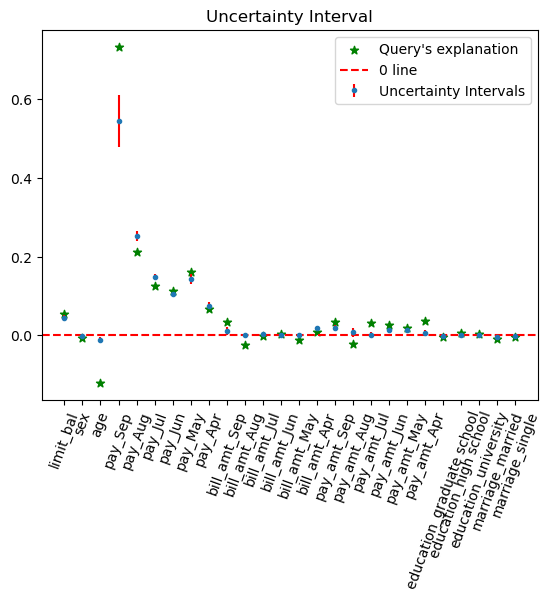

In [24]:
# visualize the uncertainty intervals of Shapley values
shap_values_local = xgb_df['shap_con']

n_feature=xgb_test.shape[1]
errors=np.zeros([2,n_feature])
y_l = shap_ci.mean(axis=1) - np.transpose(shap_ci)[0,:]
y_u =np.transpose(shap_ci)[1,:]-shap_ci.mean(axis=1)

errors[0,:]=y_l
errors[1,:]=y_u
errors
plt.errorbar(np.arange(n_feature),shap_ci.mean(axis=1),yerr=errors,fmt='.', ecolor = 'red',label="Uncertainty Intervals")
plt.scatter(np.arange(n_feature),shap_values_local,marker='*',color="green",label="Query's explanation")#shapley value for the sigle instance 
plt.axhline(y=0, color='r', linestyle='--',label="0 line")
plt.title("Uncertainty Interval")
x=X_train.columns.values
default_x_ticks = range(len(x))
plt.legend()
plt.xticks(default_x_ticks, x, rotation=70.)

([<matplotlib.axis.XTick at 0x29865c00460>,
 [Text(0, 0, 'limit_bal'),
  Text(1, 0, 'sex'),
  Text(2, 0, 'age'),
  Text(3, 0, 'pay_Sep'),
  Text(4, 0, 'pay_Aug'),
  Text(5, 0, 'pay_Jul'),
  Text(6, 0, 'pay_Jun'),
  Text(7, 0, 'pay_May'),
  Text(8, 0, 'pay_Apr'),
  Text(9, 0, 'bill_amt_Sep'),
  Text(10, 0, 'bill_amt_Aug'),
  Text(11, 0, 'bill_amt_Jul'),
  Text(12, 0, 'bill_amt_Jun'),
  Text(13, 0, 'bill_amt_May'),
  Text(14, 0, 'bill_amt_Apr'),
  Text(15, 0, 'pay_amt_Sep'),
  Text(16, 0, 'pay_amt_Aug'),
  Text(17, 0, 'pay_amt_Jul'),
  Text(18, 0, 'pay_amt_Jun'),
  Text(19, 0, 'pay_amt_May'),
  Text(20, 0, 'pay_amt_Apr'),
  Text(21, 0, 'education_graduate school'),
  Text(22, 0, 'education_high school'),
  Text(23, 0, 'education_university'),
  Text(24, 0, 'marriage_married'),
  Text(25, 0, 'marriage_single')])

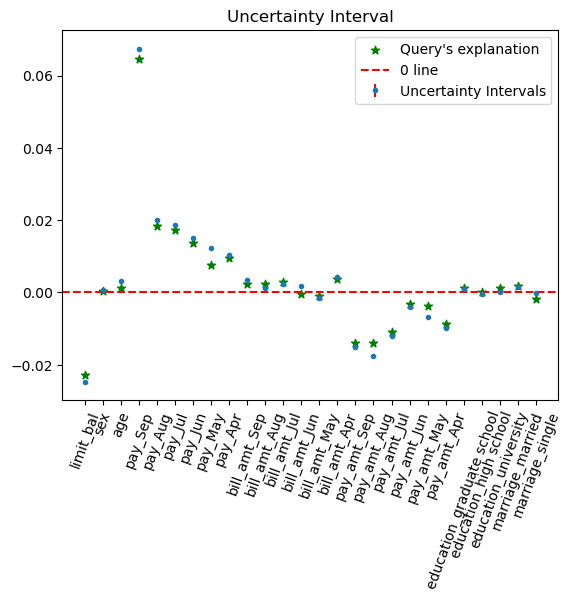

In [20]:
# visualize the uncertainty intervals of LIME coefficient
lime_value_local=xgb_df['lime_con']

n_feature=xgb_test.shape[1]
errors=np.zeros([2,n_feature])
y_l = lime_ci.mean(axis=1) - np.transpose(lime_ci)[0,:]
y_u =np.transpose(lime_ci)[1,:]-lime_ci.mean(axis=1)

errors[0,:]=y_l
errors[1,:]=y_u
errors
plt.errorbar(np.arange(n_feature),lime_ci.mean(axis=1),yerr=errors,fmt='.', ecolor = 'red',label="Uncertainty Intervals")
plt.scatter(np.arange(n_feature),lime_value_local,marker='*',color="green",label="Query's explanation")#shapley value for the sigle instance 
plt.axhline(y=0, color='r', linestyle='--',label="0 line")
plt.title("Uncertainty Interval")
x=X_train.columns.values
default_x_ticks = range(len(x))
plt.legend()
plt.xticks(default_x_ticks, x, rotation=70.)
# green stars are the shapley values for the choosen instance and the red lines are the CI.

In [16]:
#LIME coefficients uncertainty interval
lime_ci

array([[-1.24859795e+00, -1.21483292e+00],
       [ 2.39109881e-02,  5.81948203e-02],
       [ 1.37021918e-01,  1.68936014e-01],
       [ 3.32359958e+00,  3.39919953e+00],
       [ 9.89086262e-01,  1.02086939e+00],
       [ 9.21838148e-01,  9.54332901e-01],
       [ 7.38330313e-01,  7.71554396e-01],
       [ 5.98562602e-01,  6.31259725e-01],
       [ 4.97183850e-01,  5.31446660e-01],
       [ 1.52911806e-01,  1.85749431e-01],
       [ 4.36476967e-02,  7.44768571e-02],
       [ 1.00779767e-01,  1.34498402e-01],
       [ 7.36029324e-02,  1.07888197e-01],
       [-9.34339783e-02, -6.19554463e-02],
       [ 1.94585882e-01,  2.26946682e-01],
       [-7.66461552e-01, -7.35620706e-01],
       [-8.96603381e-01, -8.63572030e-01],
       [-6.20412495e-01, -5.90270176e-01],
       [-2.10232878e-01, -1.77982733e-01],
       [-3.51680035e-01, -3.20027350e-01],
       [-5.13875886e-01, -4.80993890e-01],
       [ 2.72665930e-02,  6.01416483e-02],
       [-4.13099937e-02, -8.69448759e-03],
       [-4.

In [30]:
#Shapley values uncertainty intervals
shap_ci

array([[ 3.61010246e-02,  5.12866825e-02],
       [-4.57592588e-03, -3.60364706e-04],
       [-1.66658144e-02, -3.89512768e-03],
       [ 4.79469717e-01,  6.11680508e-01],
       [ 2.39103377e-01,  2.65917808e-01],
       [ 1.43542975e-01,  1.55862108e-01],
       [ 1.00448444e-01,  1.09894648e-01],
       [ 1.29762933e-01,  1.55793518e-01],
       [ 6.64181262e-02,  8.45124200e-02],
       [ 2.43550283e-03,  2.19556112e-02],
       [-2.70242710e-03,  4.08735126e-03],
       [ 2.72590178e-03,  6.25064224e-03],
       [ 5.88460942e-04,  4.21588216e-03],
       [-9.37640783e-04,  3.93231306e-03],
       [ 1.45560792e-02,  2.36611851e-02],
       [ 1.10836476e-02,  2.63164882e-02],
       [-4.48221108e-03,  1.99551508e-02],
       [-5.08622313e-03,  8.37832317e-03],
       [ 9.22014751e-03,  1.70386676e-02],
       [ 9.29804798e-03,  1.96407028e-02],
       [-9.25685745e-05,  1.51190460e-02],
       [-3.71279358e-03, -7.95714557e-04],
       [-2.27434677e-03,  3.46830068e-03],
       [-6.